In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import time

In [2]:
start_total = time.time()

In [3]:
"""Settings for the plots"""
plt.style.use('fast')
plt.rc('figure', figsize=(16, 9))

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

In [4]:
def Gaussian(x,mu,sigma,A,C):
    """Standard Gaussian equation.
    """
    return C + A*np.exp(-0.5*((x-mu)/sigma)**2)

def Sv_freq_func(nu,alpha):
    """Returns the flux density in Jy as a function the frequency nu in GHz and alpha.
    """
    return nu**alpha

def Sv_time_func(X):
    """A function that changes over time between 0.3 and 1.3.
    """
    return Gaussian(X+70,150,50,0.5,0.5) + 0.2*np.sin((abs(X+70)/20)**1.5)*np.sin((X+70)/20)

def Polynomial(x,*P):
    """A polynomial of len(P) degree, where P are the parameters.
    """
    result = 0
    for i,p in enumerate(P):
        result += p*(x**i)
    
    return result

In [5]:
"""Dictionary to store all the data in."""
data_dict = {}

# Creating data

In [6]:
"""Flux density as a function of frequency."""
bw_low = 12   # GHz
bw_up = 18   # GHz
freq_bins = 48   # Nr of frequency bins

freqs1 = np.linspace(bw_low,bw_up,freq_bins)   # Full bandwidth (48 bins)
bw_up1 = 18   # for plots

freqs2 = freqs1[np.where(freqs1<=15)]   # 12-15 GHz (24 bins)
bw_up2 = 15   # for plots

freqs3 = freqs2[np.where(freqs2<=12)]   # 12 GHz (1 bin)
bw_up3 = 12   # for plots

# Evaluating the frequency function for each bandwidth
Sv_freq1 = np.array(Sv_freq_func(freqs1,-1))*1000   # mJy
Sv_freq2 = np.array(Sv_freq_func(freqs2,-1))*1000   # mJy
Sv_freq3 = np.array(Sv_freq_func(freqs3,-1))*1000   # mJy

data_dict["Sv_freqs"] = [Sv_freq1,Sv_freq2,Sv_freq3]
data_dict["freqs"] = [freqs1,freqs2,freqs3]

In [7]:
step_size = 24*6   # To switch between days and 10 minute bins

In [8]:
"""Total time-varying SED across 2000 days. t=0 is at the start of day 1001. This gives time-delayed images 
consistent data from before this signal. E.g. image A has a signal at t=0. If the delay for B is 200 days, 
the time delayed signal is measured at t=200. The flux density for B from before t=200 is taken from day 801 
of the SED."""
time_start = 0   # days
time_end = 150   # days
time_bins = ((time_end-time_start)*step_size)+1   # 1 bin == 10 minutes, given that time_end is integer
times = np.linspace(time_start,time_end,time_bins)   # days

# Fast varying function of time
Sv_time1 = Sv_time_func(times) + 0.1

# Medium varying function of time, made by fitting a polynomial through some random points
scatter_size = 6
time_fit_data = np.array([0.3,0.7,0.5,0.8,0.4,0.6])
time_fit_times = np.linspace(time_start,time_end,scatter_size)
time_popt, _ = curve_fit(Polynomial, time_fit_times, time_fit_data, p0=range(scatter_size))
Sv_time2 = 1.2*Polynomial(times,time_popt[0],time_popt[1],time_popt[2],time_popt[3],time_popt[4],time_popt[5]) + 0.2

# Slow varying function of time
Sv_time3 = Gaussian(times,150,70,0.6,0.2) + Gaussian(times,200,100,0.2,0) + 0.2

data_dict["Sv_time"] = [Sv_time1,Sv_time2,Sv_time3]

/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [9]:
"""Combining the frequency and time functions to obtain time-frequency spectra."""
data_comb11 = np.outer(Sv_freq1,Sv_time1)
data_comb12 = np.outer(Sv_freq1,Sv_time2)
data_comb13 = np.outer(Sv_freq1,Sv_time3)
data_comb21 = np.outer(Sv_freq2,Sv_time1)
data_comb22 = np.outer(Sv_freq2,Sv_time2)
data_comb23 = np.outer(Sv_freq2,Sv_time3)
data_comb31 = np.outer(Sv_freq3,Sv_time1)
data_comb32 = np.outer(Sv_freq3,Sv_time2)
data_comb33 = np.outer(Sv_freq3,Sv_time3)

data_dict["data_comb"] = [[data_comb11,data_comb12,data_comb13],
                          [data_comb21,data_comb22,data_comb23],
                          [data_comb31,data_comb32,data_comb33]]

# Sampling

In [10]:
"""Delays and intensities."""
AB_delay = (1.2)*step_size   # 1.2 days
AC_delay = (10.72)*step_size   # 10 days
AD_delay = (39.899)*step_size   # 40 days

B_intensity = 0.9   # w.r.t. A
C_intensity = 0.7   # w.r.t. A
D_intensity = 0.4   # w.r.t. A

# Sample is 100 days
time_start_sample = 0
time_end_sample = 100

In [11]:
"""Measurement spacing."""
measure_times1 = np.arange(0,(time_end_sample-time_start_sample)*step_size+1,2*step_size)   # Regular 2 day sampling
measure_times2 = np.arange(0,(time_end_sample-time_start_sample)*step_size+1,10*step_size)   # Regular 10 day sampling
measure_times3 = np.array([0,1,2,4,6,18,19,21,22,37,38,40,62,63,81,97,98,99,100])*step_size   # Irregular sampling

data_dict["measure_times"] = [measure_times1,measure_times2,measure_times3]

In [12]:
"""Creating a space to store the samples."""
data_dict["sample_sets"] = [[[0,0,0],[0,0,0],[0,0,0],[0,0,0]],
                            [[0,0,0],[0,0,0],[0,0,0],[0,0,0]],
                            [[0,0,0],[0,0,0],[0,0,0],[0,0,0]]]

for m in range(len(data_dict["Sv_freqs"])):
    for k in range(len(data_dict["measure_times"])):
        for i in range(len(data_dict["data_comb"])):
            data_dict["sample_sets"][m][k][i] = np.zeros([4,len(data_dict["data_comb"][m][i]),
                                                          len(data_dict["measure_times"][k])])

In [13]:
"""Sampling the data for each combination of parameters."""
for m in range(len(data_dict["Sv_freqs"])):
    for k in range(len(data_dict["measure_times"])):
        for i in range(len(data_dict["data_comb"])):
            data = data_dict["data_comb"][m][i]
            meas = data_dict["measure_times"][k]
            samp = data_dict["sample_sets"][m][k][i]
            
            A_data = np.zeros([len(data),len(meas)])
            B_data = np.zeros([len(data),len(meas)])
            C_data = np.zeros([len(data),len(meas)])
            D_data = np.zeros([len(data),len(meas)])
            
            for j in range(len(meas)):
                A_data[:,j] = data[:,int(meas[j])]
                B_data[:,j] = B_intensity*data[:,int(meas[j]+AB_delay)]
                C_data[:,j] = C_intensity*data[:,int(meas[j]+AC_delay)]
                D_data[:,j] = D_intensity*data[:,int(meas[j]+AD_delay)]
            
            # plus ~0.5% of Sv_freq noise per frequency channel
            for l in range(len(data_dict["freqs"][m])):
                samp[0][l] = A_data[l] + np.random.normal(loc=0.005*data_dict["Sv_freqs"][m][l],size=A_data[l].shape)
                samp[1][l] = B_data[l] + np.random.normal(loc=0.005*data_dict["Sv_freqs"][m][l],size=B_data[l].shape)
                samp[2][l] = C_data[l] + np.random.normal(loc=0.005*data_dict["Sv_freqs"][m][l],size=C_data[l].shape)
                samp[3][l] = D_data[l] + np.random.normal(loc=0.005*data_dict["Sv_freqs"][m][l],size=D_data[l].shape)

# Analysis

## Interpolation

In [14]:
"""Creating a space to store the interpolation times."""
data_dict["full_times"] = [0,0,0]

for k in range(len(data_dict["measure_times"])):
    data_dict["full_times"][k] = np.arange(data_dict["measure_times"][k][0],data_dict["measure_times"][k][-1]+1,1)

In [15]:
"""Creating a space to store the interpolated data."""
data_dict["inter_sets"] = [[[0,0,0],[0,0,0],[0,0,0],[0,0,0]],
                           [[0,0,0],[0,0,0],[0,0,0],[0,0,0]],
                           [[0,0,0],[0,0,0],[0,0,0],[0,0,0]]]

for m in range(len(data_dict["Sv_freqs"])):
    for k in range(len(data_dict["measure_times"])):
        for i in range(len(data_dict["data_comb"])):
            data_dict["inter_sets"][m][k][i] = np.zeros([4,len(data_dict["sample_sets"][m][k][i][0]),
                                                         len(data_dict["full_times"][k])])

In [16]:
"""Interpolating the sampled data."""
start = time.time()
for m in range(len(data_dict["Sv_freqs"])):
    for k in range(len(data_dict["measure_times"])):
        for i in range(len(data_dict["data_comb"])):
            meas = data_dict["measure_times"][k]
            samp = data_dict["sample_sets"][m][k][i]
            full = data_dict["full_times"][i]
            inter = data_dict["inter_sets"][m][k][i]
            
            for j in range(len(samp[0])):
                inter_func1 = interp1d(meas, samp[0][j], 'cubic')
                inter_func2 = interp1d(meas, samp[1][j], 'cubic')
                inter_func3 = interp1d(meas, samp[2][j], 'cubic')
                inter_func4 = interp1d(meas, samp[3][j], 'cubic')
                
                full_data_A = inter_func1(full)
                full_data_B = inter_func2(full)
                full_data_C = inter_func3(full)
                full_data_D = inter_func4(full)
                
                inter[0][j] = full_data_A
                inter[1][j] = full_data_B
                inter[2][j] = full_data_C
                inter[3][j] = full_data_D

end = time.time()
print(end - start)

2.4660799503326416


## Delays, flux ratios and intensities

In [17]:
"""Defining the delay estimates."""
AB_delay_min = -4*step_size
AB_delay_max = 6*step_size
AB_delay_estimates = np.arange(AB_delay_min,AB_delay_max,1)

AC_delay_min = 5*step_size
AC_delay_max = 15*step_size
AC_delay_estimates = np.arange(AC_delay_min,AC_delay_max,1)

AD_delay_min = 35*step_size
AD_delay_max = 45*step_size
AD_delay_estimates = np.arange(AD_delay_min,AD_delay_max,1)

In [18]:
"""Creating a space to store the delays."""
data_dict["delay_arrays"] = [[[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]],
                             [[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]],
                             [[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]]]

data_dict["delay_means"] = [[[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]],
                            [[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]],
                            [[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]]]

data_dict["delay_stds"] = [[[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]],
                           [[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]],
                           [[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]]]

In [19]:
"""Checks stds around an estimate and takes the delay with the smallest std as the correct delay"""
start = time.time()
for m in range(len(data_dict["Sv_freqs"])):
    for i in range(len(data_dict["data_comb"])):
        for k in range(len(data_dict["measure_times"])):
            inter = data_dict["inter_sets"][m][k][i]
            
            AB_ratio = np.zeros([len(data_dict["freqs"][m]),len(AB_delay_estimates)])
            AB_ratio_stds = np.zeros([len(data_dict["freqs"][m]),len(AB_delay_estimates)])
            AC_ratio = np.zeros([len(data_dict["freqs"][m]),len(AC_delay_estimates)])
            AC_ratio_stds = np.zeros([len(data_dict["freqs"][m]),len(AC_delay_estimates)])
            AD_ratio = np.zeros([len(data_dict["freqs"][m]),len(AD_delay_estimates)])
            AD_ratio_stds = np.zeros([len(data_dict["freqs"][m]),len(AD_delay_estimates)])
            
            for j in AB_delay_estimates:
                j += 1
                if j<0:
                    for l in range(len(data_dict["freqs"][m])):
                        AB_ratios = inter[0][l][:j]/inter[1][l][-j:]
                        AB_ratio[l][j-1-AB_delay_estimates[0]] = np.mean(AB_ratios)
                        AB_ratio_stds[l][j-1-AB_delay_estimates[0]] = np.std(AB_ratios)
                elif j==0:
                    for l in range(len(data_dict["freqs"][m])):
                        AB_ratios = inter[0][l][:]/inter[1][l][:]
                        AB_ratio[l][j-1-AB_delay_estimates[0]] = np.mean(AB_ratios)
                        AB_ratio_stds[l][j-1-AB_delay_estimates[0]] = np.std(AB_ratios)
                else:
                    for l in range(len(data_dict["freqs"][m])):
                        AB_ratios = inter[0][l][j:]/inter[1][l][:-j]
                        AB_ratio[l][j-1-AB_delay_estimates[0]] = np.mean(AB_ratios)
                        AB_ratio_stds[l][j-1-AB_delay_estimates[0]] = np.std(AB_ratios)
            
            for j in AC_delay_estimates:
                j += 1
                for l in range(len(data_dict["freqs"][m])):
                    AC_ratios = inter[0][l][j:]/inter[2][l][:-j]
                    AC_ratio[l][j-1-AC_delay_estimates[0]] = np.mean(AC_ratios)
                    AC_ratio_stds[l][j-1-AC_delay_estimates[0]] = np.std(AC_ratios)
            
            for j in AD_delay_estimates:
                j += 1
                for l in range(len(data_dict["freqs"][m])):
                    AD_ratios = inter[0][l][j:]/inter[3][l][:-j]
                    AD_ratio[l][j-1-AD_delay_estimates[0]] = np.mean(AD_ratios)
                    AD_ratio_stds[l][j-1-AD_delay_estimates[0]] = np.std(AD_ratios)
            
            AB_delay_calc = np.zeros(len(data_dict["freqs"][m]))
            AC_delay_calc = np.zeros(len(data_dict["freqs"][m]))
            AD_delay_calc = np.zeros(len(data_dict["freqs"][m]))
            
            for l in range(len(data_dict["freqs"][m])):
                AB_delay_calc[l] = int(AB_delay_min+(AB_delay_max-AB_delay_min)*np.where(AB_ratio_stds[l]==np.min(AB_ratio_stds[l]))[0][0]/len(AB_ratio_stds[l]))
                AC_delay_calc[l] = int(AC_delay_min+(AC_delay_max-AC_delay_min)*np.where(AC_ratio_stds[l]==np.min(AC_ratio_stds[l]))[0][0]/len(AC_ratio_stds[l]))
                AD_delay_calc[l] = int(AD_delay_min+(AD_delay_max-AD_delay_min)*np.where(AD_ratio_stds[l]==np.min(AD_ratio_stds[l]))[0][0]/len(AD_ratio_stds[l]))
            
            
            data_dict["delay_arrays"][m][k][i] = [AB_delay_calc,AC_delay_calc,AD_delay_calc]

end = time.time()
print(end - start)

175.5142960548401


In [20]:
"""Obtaining the means and stds of the delays."""
for m in range(len(data_dict["Sv_freqs"])):
    for k in range(len(data_dict["measure_times"])):
        for i in range(len(data_dict["data_comb"])):
            data_dict["delay_means"][m][k][i][0] = np.mean(data_dict["delay_arrays"][m][k][i][0])
            data_dict["delay_stds"][m][k][i][0] = np.std(data_dict["delay_arrays"][m][k][i][0])
            data_dict["delay_means"][m][k][i][1] = np.mean(data_dict["delay_arrays"][m][k][i][1])
            data_dict["delay_stds"][m][k][i][1] = np.std(data_dict["delay_arrays"][m][k][i][1])
            data_dict["delay_means"][m][k][i][2] = np.mean(data_dict["delay_arrays"][m][k][i][2])
            data_dict["delay_stds"][m][k][i][2] = np.std(data_dict["delay_arrays"][m][k][i][2])

In [21]:
"""Creating a space to store the flux ratios."""
data_dict["flux_ratio_means"] = [[[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]],
                                 [[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]],
                                 [[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]]]

data_dict["flux_ratio_stds"] = [[[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]],
                                [[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]],
                                [[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]]]

In [22]:
"""Calculating the flux ratio for each delay."""
for m in range(len(data_dict["Sv_freqs"])):
    for k in range(len(data_dict["measure_times"])):
        for i in range(len(data_dict["data_comb"])):
            inter = data_dict["inter_sets"][m][k][i]
            delays = data_dict["delay_means"][m][k][i]
            
            if int(delays[0])==0:
                AB_ratio = inter[0][:,:]/inter[1][:,:]
                AB_ratio_mean = np.mean(AB_ratio)
                AB_ratio_std = np.std(AB_ratio)
            else:
                AB_ratio = inter[0][:,int(delays[0]):]/inter[1][:,:-int(delays[0])]
                AB_ratio_mean = np.mean(AB_ratio)
                AB_ratio_std = np.std(AB_ratio)
            
            if int(delays[1])==0:
                AC_ratio = inter[0][:,:]/inter[2][:,:]
                AC_ratio_mean = np.mean(AC_ratio)
                AC_ratio_std = np.std(AC_ratio)
            else:
                AC_ratio = inter[0][:,int(delays[1]):]/inter[2][:,:-int(delays[1])]
                AC_ratio_mean = np.mean(AC_ratio)
                AC_ratio_std = np.std(AC_ratio)
            
            if int(delays[2])==0:
                AD_ratio = inter[0][:,:]/inter[3][:,:]
                AD_ratio_mean = np.mean(AD_ratio)
                AD_ratio_std = np.std(AD_ratio)
            else:
                AD_ratio = inter[0][:,int(delays[2]):]/inter[3][:,:-int(delays[2])]
                AD_ratio_mean = np.mean(AD_ratio)
                AD_ratio_std = np.std(AD_ratio)
            
            data_dict["flux_ratio_means"][m][k][i] = [AB_ratio_mean,AC_ratio_mean,AD_ratio_mean]
            data_dict["flux_ratio_stds"][m][k][i] = [AB_ratio_std,AC_ratio_std,AD_ratio_std]

## Recombining

In [25]:
"""Creating a space to store the recombined dataset."""
data_dict["new_dataset"] = [[[0,0,0],[0,0,0],[0,0,0]],
                            [[0,0,0],[0,0,0],[0,0,0]],
                            [[0,0,0],[0,0,0],[0,0,0]]]

In [26]:
"""Combining our interpolated image data into one spectrum. Delays and intensity differences 
are corrected for, overlapping points are averaged."""
start = time.time()
for m in range(len(data_dict["Sv_freqs"])):
    for k in range(len(data_dict["measure_times"])):
        for i in range(len(data_dict["data_comb"])):
            inter = data_dict["inter_sets"][m][k][i]
            delays = data_dict["delay_means"][m][k][i]
            ratio = data_dict["flux_ratio_means"][m][k][i]
            
            # Determining the order of the signals (B can change places with A or C)
            if delays[0] < 0:
                # [B,A,C,D]
                ordered_inter = [inter[1],inter[0],inter[2],inter[3]]
                ordered_delays = [0,0-delays[0],delays[1]-delays[0],delays[2]-delays[0]]
                ordered_ratio = [ratio[0],1,ratio[1],ratio[2]]
            elif delays[0] > delays[1]:
                # [A,C,B,D]
                ordered_inter = [inter[0],inter[2],inter[1],inter[3]]
                ordered_delays = [0,delays[1],delays[0],delays[2]]
                ordered_ratio = [1,ratio[1],ratio[0],ratio[2]]
            else:
                # [A,B,C,D]
                ordered_inter = [inter[0],inter[1],inter[2],inter[3]]
                ordered_delays = [0,delays[0],delays[1],delays[2]]
                ordered_ratio = [1,ratio[0],ratio[1],ratio[2]]
            
            # Getting the right shape of the new data prepared
            data_dict["new_dataset"][m][k][i] = np.zeros([len(ordered_inter[0]),
                                                          len(ordered_inter[0][0])+int(ordered_delays[-1]-ordered_delays[0])])
            new_data = data_dict["new_dataset"][m][k][i]
            
            for i in range(len(inter[0][0])+int(ordered_delays[-1]-ordered_delays[0])):
                # Only from first
                if i<int(ordered_delays[1]):
                    new_data[:,i] = ordered_ratio[0]*ordered_inter[0][:,i-int(ordered_delays[0])]
                    
                # From first and second
                elif int(ordered_delays[1])<=i<int(ordered_delays[2]):
                    data_mean = np.mean([ordered_ratio[0]*ordered_inter[0][:,i-int(ordered_delays[0])],
                                         ordered_ratio[1]*ordered_inter[1][:,i-int(ordered_delays[1])]],axis=0)
                    new_data[:,i] = data_mean
                
                # From first, second and third
                elif int(ordered_delays[2])<=i<int(ordered_delays[3]):
                    data_mean = np.mean([ordered_ratio[0]*ordered_inter[0][:,i-int(ordered_delays[0])],
                                         ordered_ratio[1]*ordered_inter[1][:,i-int(ordered_delays[1])],
                                         ordered_ratio[2]*ordered_inter[2][:,i-int(ordered_delays[2])]],axis=0)
                    new_data[:,i] = data_mean
                
                # From first, second, third and fourth
                elif int(ordered_delays[3])<=i<time_end_sample*step_size:
                    data_mean = np.mean([ordered_ratio[0]*ordered_inter[0][:,i-int(ordered_delays[0])],
                                         ordered_ratio[1]*ordered_inter[1][:,i-int(ordered_delays[1])],
                                         ordered_ratio[2]*ordered_inter[2][:,i-int(ordered_delays[2])],
                                         ordered_ratio[3]*ordered_inter[3][:,i-int(ordered_delays[3])]],axis=0)
                    new_data[:,i] = data_mean
                
                # From second, third and fourth
                elif time_end_sample*step_size<=i<time_end_sample*step_size+int(ordered_delays[1]):
                    data_mean = np.mean([ordered_ratio[1]*ordered_inter[1][:,i-int(ordered_delays[1])],
                                         ordered_ratio[2]*ordered_inter[2][:,i-int(ordered_delays[2])],
                                         ordered_ratio[3]*ordered_inter[3][:,i-int(ordered_delays[3])]],axis=0)
                    new_data[:,i] = data_mean
                
                # From third and fourth
                elif time_end_sample*step_size+int(ordered_delays[1])<=i<time_end_sample*step_size+int(ordered_delays[2]):
                    data_mean = np.mean([ordered_ratio[2]*ordered_inter[2][:,i-int(ordered_delays[2])],
                                         ordered_ratio[3]*ordered_inter[3][:,i-int(ordered_delays[3])]],axis=0)
                    new_data[:,i] = data_mean
                
                # Only from fourth
                else:
                    new_data[:,i] = ordered_ratio[3]*ordered_inter[3][:,i-int(ordered_delays[3])]

end = time.time()
print(end - start)

10.144710779190063


In [123]:
"""Determining what time range the recombined dataset actually measured (~140 days)."""
time_start_meas = [[[0,0,0],[0,0,0],[0,0,0]],
                   [[0,0,0],[0,0,0],[0,0,0]],
                   [[0,0,0],[0,0,0],[0,0,0]]]
time_end_meas = [[[0,0,0],[0,0,0],[0,0,0]],
                 [[0,0,0],[0,0,0],[0,0,0]],
                 [[0,0,0],[0,0,0],[0,0,0]]]
times_meas = [[[0,0,0],[0,0,0],[0,0,0]],
              [[0,0,0],[0,0,0],[0,0,0]],
              [[0,0,0],[0,0,0],[0,0,0]]]

for m in range(len(data_dict["Sv_freqs"])):
    for k in range(len(data_dict["measure_times"])):
        for i in range(len(data_dict["data_comb"])):
            delays = data_dict["delay_means"][m][k][i]
            
            if delays[0] < 0:
                # [B,A,C,D]
                ordered_delays = [delays[0],0,delays[1],delays[2]]
            elif delays[0] > delays[1]:
                # [A,C,B,D]
                ordered_delays = [0,delays[1],delays[0],delays[2]]
            else:
                # [A,B,C,D]
                ordered_delays = [0,delays[0],delays[1],delays[2]]
            
            time_start_meas[m][k][i] = time_start_sample + ordered_delays[0]/step_size
            time_end_meas[m][k][i] = time_end_sample + ordered_delays[-1]/step_size
            
            time_bins_meas = int(((time_end_meas[m][k][i]-time_start_meas[m][k][i])*step_size)+1)
            times_meas[m][k][i] = np.linspace(time_start_meas[m][k][i],time_end_meas[m][k][i],time_bins_meas)

# Plots

## Freq and time functions

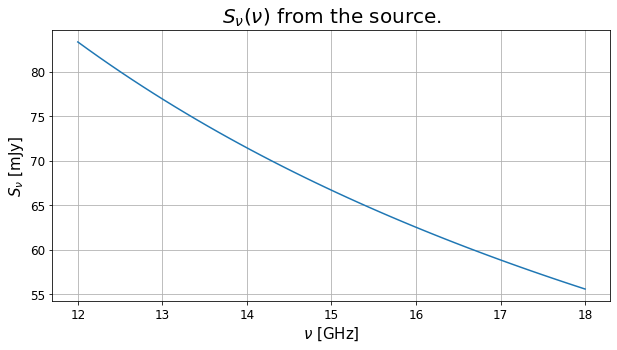

In [28]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot(freqs1, Sv_freq1)

frame.set_title(r'$S_{\nu}(\nu)$ from the source.')
frame.set_xlabel(r'$\nu\ [\mathrm{GHz}]$')
frame.set_ylabel(r'$S_{\nu}\ [\mathrm{mJy}]$')
frame.set_aspect('auto')
frame.grid()

plt.show()

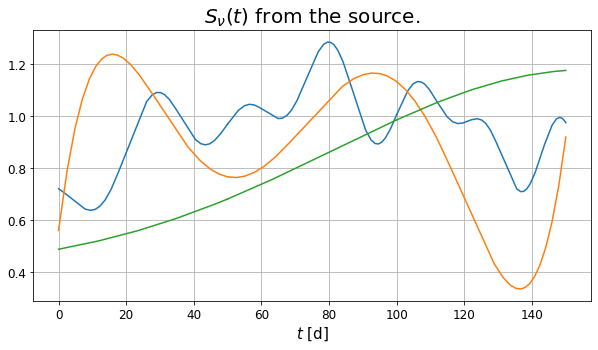

In [146]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot(times, data_dict["Sv_time"][0])
frame.plot(times, data_dict["Sv_time"][1])
frame.plot(times, data_dict["Sv_time"][2])

frame.set_title(r'$S_{\nu}(t)$ from the source.')
# frame.set_title(r'$S_{\nu}(t)$ from each image.')
frame.set_xlabel(r'$t\ [\mathrm{d}]$')
# frame.set_ylabel(r'$S_{\nu}\ [\mathrm{mJy}]$')
frame.set_aspect('auto')
frame.grid()
# frame.legend()

plt.show()

## Source spectra

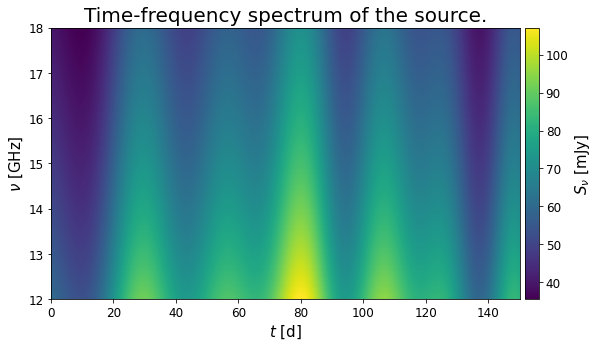

In [30]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()
image = frame.imshow(data_dict["data_comb"][0][0], origin='lower', extent=[time_start,time_end,bw_low,bw_up1])
fig.colorbar(image, ax=frame, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

frame.set_title(r'Time-frequency spectrum of the source.')
frame.set_xlabel(r'$t\ [\mathrm{d}]$')
frame.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')
frame.set_aspect('auto')

plt.show()

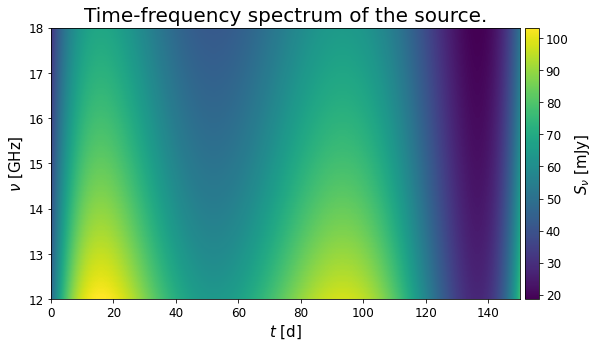

In [31]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()
image = frame.imshow(data_dict["data_comb"][0][1], origin='lower', extent=[time_start,time_end,bw_low,bw_up1])
fig.colorbar(image, ax=frame, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

frame.set_title(r'Time-frequency spectrum of the source.')
frame.set_xlabel(r'$t\ [\mathrm{d}]$')
frame.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')
frame.set_aspect('auto')

plt.show()

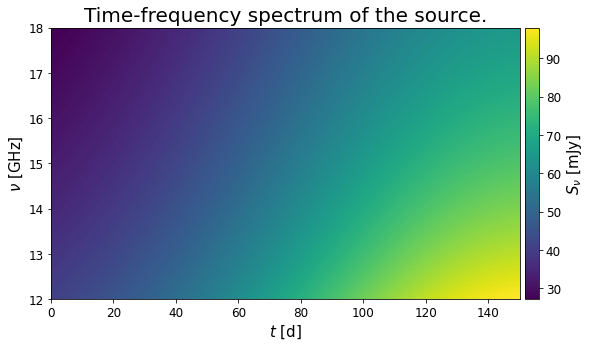

In [32]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()
image = frame.imshow(data_dict["data_comb"][0][2], origin='lower', extent=[time_start,time_end,bw_low,bw_up1])
fig.colorbar(image, ax=frame, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

frame.set_title(r'Time-frequency spectrum of the source.')
frame.set_xlabel(r'$t\ [\mathrm{d}]$')
frame.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')
frame.set_aspect('auto')

plt.show()

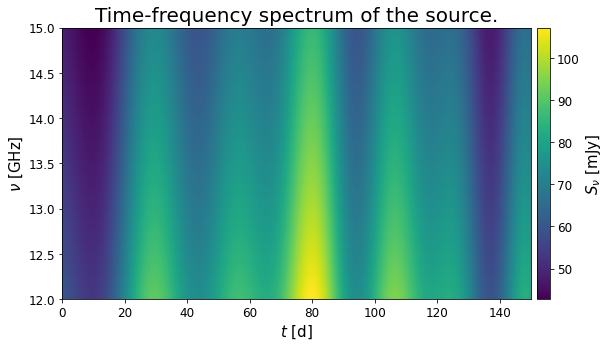

In [33]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()
image = frame.imshow(data_dict["data_comb"][1][0], origin='lower', extent=[time_start,time_end,bw_low,bw_up2])
fig.colorbar(image, ax=frame, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

frame.set_title(r'Time-frequency spectrum of the source.')
frame.set_xlabel(r'$t\ [\mathrm{d}]$')
frame.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')
frame.set_aspect('auto')

plt.show()

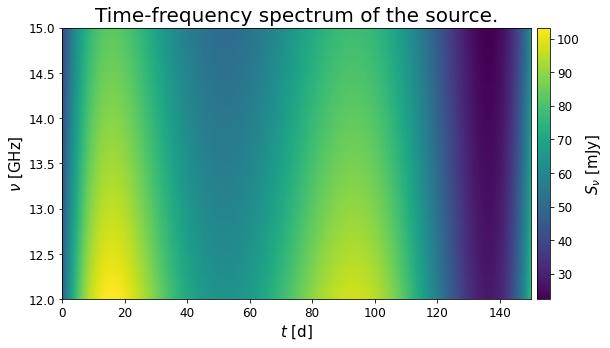

In [34]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()
image = frame.imshow(data_dict["data_comb"][1][1], origin='lower', extent=[time_start,time_end,bw_low,bw_up2])
fig.colorbar(image, ax=frame, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

frame.set_title(r'Time-frequency spectrum of the source.')
frame.set_xlabel(r'$t\ [\mathrm{d}]$')
frame.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')
frame.set_aspect('auto')

plt.show()

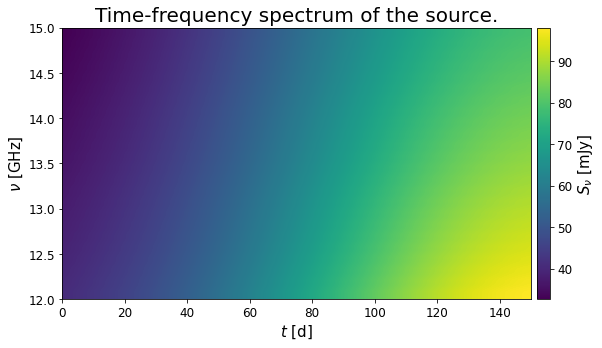

In [35]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()
image = frame.imshow(data_dict["data_comb"][1][2], origin='lower', extent=[time_start,time_end,bw_low,bw_up2])
fig.colorbar(image, ax=frame, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

frame.set_title(r'Time-frequency spectrum of the source.')
frame.set_xlabel(r'$t\ [\mathrm{d}]$')
frame.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')
frame.set_aspect('auto')

plt.show()

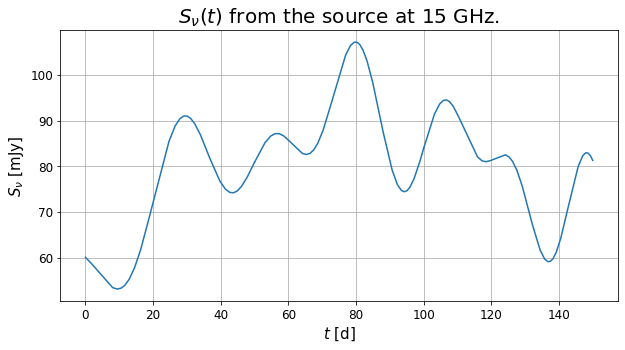

In [36]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot(times, data_dict["data_comb"][2][0][0])

frame.set_title(r'$S_{\nu}(t)$ from the source at 15 $\mathrm{GHz}$.')
frame.set_xlabel(r'$t\ [\mathrm{d}]$')
frame.set_ylabel(r'$S_{\nu}\ [\mathrm{mJy}]$')
frame.set_aspect('auto')
frame.grid()

plt.show()

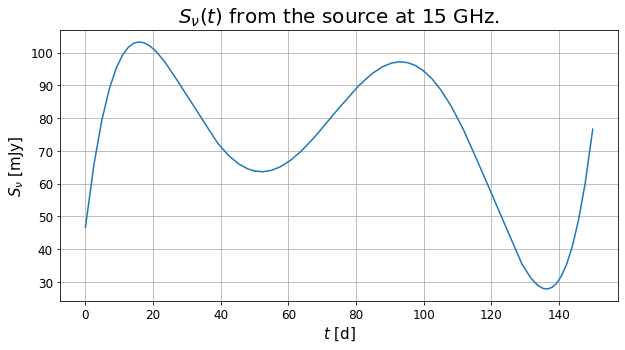

In [37]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot(times, data_dict["data_comb"][2][1][0])

frame.set_title(r'$S_{\nu}(t)$ from the source at 15 $\mathrm{GHz}$.')
frame.set_xlabel(r'$t\ [\mathrm{d}]$')
frame.set_ylabel(r'$S_{\nu}\ [\mathrm{mJy}]$')
frame.set_aspect('auto')
frame.grid()

plt.show()

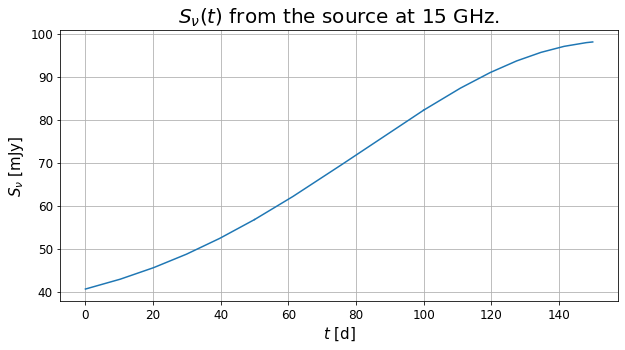

In [38]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot(times, data_dict["data_comb"][2][2][0])

frame.set_title(r'$S_{\nu}(t)$ from the source at 15 $\mathrm{GHz}$.')
frame.set_xlabel(r'$t\ [\mathrm{d}]$')
frame.set_ylabel(r'$S_{\nu}\ [\mathrm{mJy}]$')
frame.set_aspect('auto')
frame.grid()

plt.show()

## Sample examples

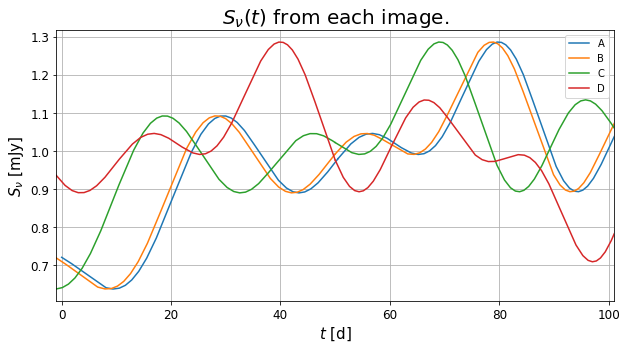

In [39]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot(times, data_dict["Sv_time"][0], label='A')
frame.plot((times-AB_delay/step_size), data_dict["Sv_time"][0], label='B')
frame.plot((times-AC_delay/step_size), data_dict["Sv_time"][0], label='C')
frame.plot((times-AD_delay/step_size), data_dict["Sv_time"][0], label='D')

frame.set_title(r'$S_{\nu}(t)$ from each image.')
frame.set_xlabel(r'$t\ [\mathrm{d}]$')
frame.set_ylabel(r'$S_{\nu}\ [\mathrm{mJy}]$')
frame.set_aspect('auto')
frame.grid()
frame.legend(loc='upper right')
frame.set_xlim(-1,101)

plt.show()

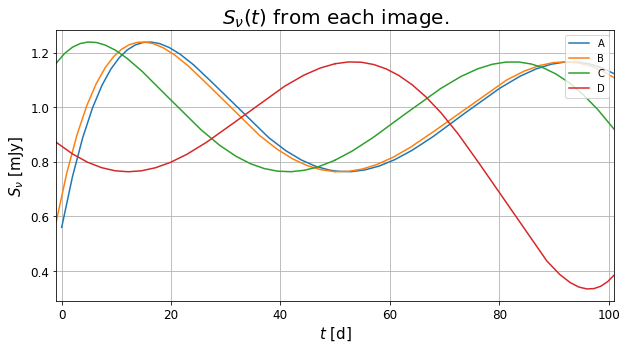

In [191]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot(times, data_dict["Sv_time"][1], label='A')
frame.plot((times-AB_delay/step_size), data_dict["Sv_time"][1], label='B')
frame.plot((times-AC_delay/step_size), data_dict["Sv_time"][1], label='C')
frame.plot((times-AD_delay/step_size), data_dict["Sv_time"][1], label='D')

frame.set_title(r'$S_{\nu}(t)$ from each image.')
frame.set_xlabel(r'$t\ [\mathrm{d}]$')
frame.set_ylabel(r'$S_{\nu}\ [\mathrm{mJy}]$')
frame.set_aspect('auto')
frame.grid()
frame.legend(loc='upper right')
frame.set_xlim(-1,101)

plt.show()

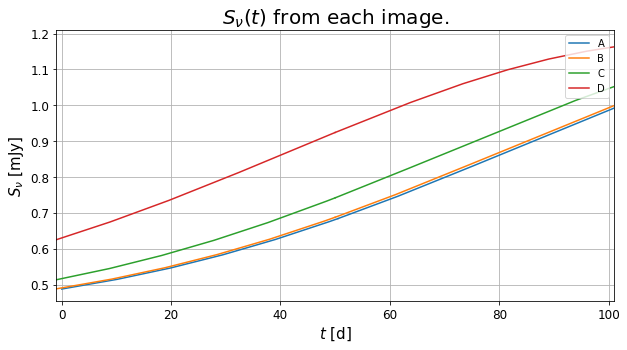

In [192]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot(times, data_dict["Sv_time"][2], label='A')
frame.plot((times-AB_delay/step_size), data_dict["Sv_time"][2], label='B')
frame.plot((times-AC_delay/step_size), data_dict["Sv_time"][2], label='C')
frame.plot((times-AD_delay/step_size), data_dict["Sv_time"][2], label='D')

frame.set_title(r'$S_{\nu}(t)$ from each image.')
frame.set_xlabel(r'$t\ [\mathrm{d}]$')
frame.set_ylabel(r'$S_{\nu}\ [\mathrm{mJy}]$')
frame.set_aspect('auto')
frame.grid()
frame.legend(loc='upper right')
frame.set_xlim(-1,101)

plt.show()

## Interpolated data

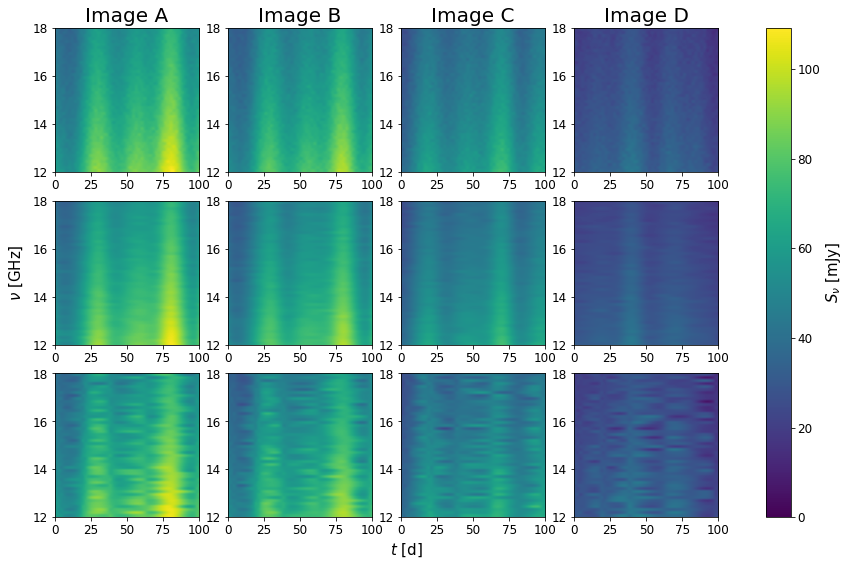

In [40]:
"""Plots of the interpolated data. Images are shown horizontally, measurement spacing is shown vertically. 
Bandwidth 1, time function 1."""

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)    # The big subplot
ax11 = fig.add_subplot(3,5,1)
ax12 = fig.add_subplot(3,5,2)
ax13 = fig.add_subplot(3,5,3)
ax14 = fig.add_subplot(3,5,4)
ax21 = fig.add_subplot(3,5,6)
ax22 = fig.add_subplot(3,5,7)
ax23 = fig.add_subplot(3,5,8)
ax24 = fig.add_subplot(3,5,9)
ax31 = fig.add_subplot(3,5,11)
ax32 = fig.add_subplot(3,5,12)
ax33 = fig.add_subplot(3,5,13)
ax34 = fig.add_subplot(3,5,14)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

m = 0
i = 0

Sv_max = np.max(data_dict["inter_sets"][m][:][i][:])

image = ax11.imshow(data_dict["inter_sets"][m][0][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax12.imshow(data_dict["inter_sets"][m][0][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax13.imshow(data_dict["inter_sets"][m][0][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax14.imshow(data_dict["inter_sets"][m][0][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax21.imshow(data_dict["inter_sets"][m][1][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax22.imshow(data_dict["inter_sets"][m][1][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax23.imshow(data_dict["inter_sets"][m][1][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax24.imshow(data_dict["inter_sets"][m][1][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax31.imshow(data_dict["inter_sets"][m][2][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax32.imshow(data_dict["inter_sets"][m][2][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax33.imshow(data_dict["inter_sets"][m][2][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax34.imshow(data_dict["inter_sets"][m][2][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])

ax11.set_aspect('auto')
ax12.set_aspect('auto')
ax13.set_aspect('auto')
ax14.set_aspect('auto')
ax21.set_aspect('auto')
ax22.set_aspect('auto')
ax23.set_aspect('auto')
ax24.set_aspect('auto')
ax31.set_aspect('auto')
ax32.set_aspect('auto')
ax33.set_aspect('auto')
ax34.set_aspect('auto')

# Set common labels
ax.set_xlabel(r'$t\ [\mathrm{d}]$')
ax.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')

ax11.set_title('Image A')
ax12.set_title('Image B')
ax13.set_title('Image C')
ax14.set_title('Image D')

# fig.colorbar(image, ax=ax)
fig.colorbar(image, ax=ax, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

plt.show()

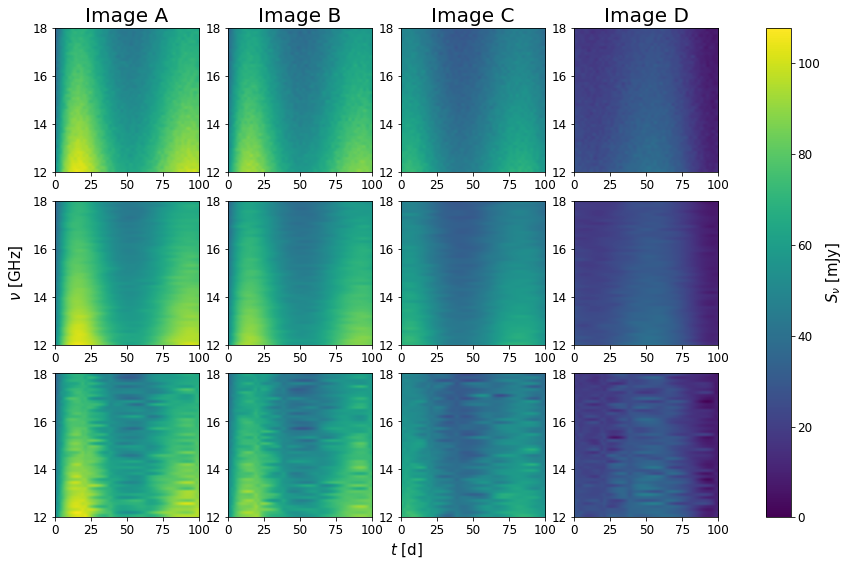

In [41]:
"""Plots of the interpolated data. Images are shown horizontally, measurement spacing is shown vertically. 
Bandwidth 1, time function 2."""

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)    # The big subplot
ax11 = fig.add_subplot(3,5,1)
ax12 = fig.add_subplot(3,5,2)
ax13 = fig.add_subplot(3,5,3)
ax14 = fig.add_subplot(3,5,4)
ax21 = fig.add_subplot(3,5,6)
ax22 = fig.add_subplot(3,5,7)
ax23 = fig.add_subplot(3,5,8)
ax24 = fig.add_subplot(3,5,9)
ax31 = fig.add_subplot(3,5,11)
ax32 = fig.add_subplot(3,5,12)
ax33 = fig.add_subplot(3,5,13)
ax34 = fig.add_subplot(3,5,14)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

m = 0
i = 1

Sv_max = np.max(data_dict["inter_sets"][m][:][i][:])

image = ax11.imshow(data_dict["inter_sets"][m][0][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax12.imshow(data_dict["inter_sets"][m][0][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax13.imshow(data_dict["inter_sets"][m][0][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax14.imshow(data_dict["inter_sets"][m][0][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax21.imshow(data_dict["inter_sets"][m][1][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax22.imshow(data_dict["inter_sets"][m][1][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax23.imshow(data_dict["inter_sets"][m][1][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax24.imshow(data_dict["inter_sets"][m][1][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax31.imshow(data_dict["inter_sets"][m][2][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax32.imshow(data_dict["inter_sets"][m][2][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax33.imshow(data_dict["inter_sets"][m][2][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax34.imshow(data_dict["inter_sets"][m][2][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])

ax11.set_aspect('auto')
ax12.set_aspect('auto')
ax13.set_aspect('auto')
ax14.set_aspect('auto')
ax21.set_aspect('auto')
ax22.set_aspect('auto')
ax23.set_aspect('auto')
ax24.set_aspect('auto')
ax31.set_aspect('auto')
ax32.set_aspect('auto')
ax33.set_aspect('auto')
ax34.set_aspect('auto')

# Set common labels
ax.set_xlabel(r'$t\ [\mathrm{d}]$')
ax.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')

ax11.set_title('Image A')
ax12.set_title('Image B')
ax13.set_title('Image C')
ax14.set_title('Image D')

# fig.colorbar(image, ax=ax)
fig.colorbar(image, ax=ax, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

plt.show()

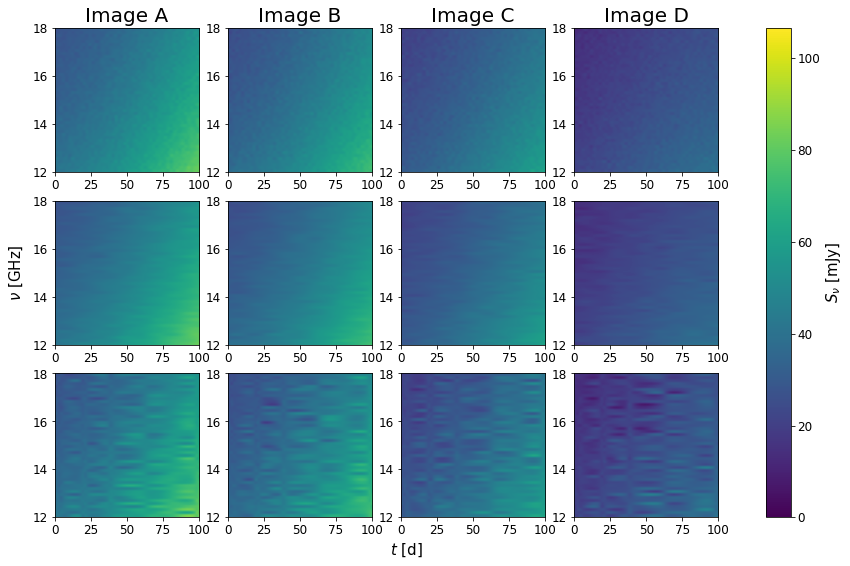

In [42]:
"""Plots of the interpolated data. Images are shown horizontally, measurement spacing is shown vertically. 
Bandwidth 1, time function 3."""

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)    # The big subplot
ax11 = fig.add_subplot(3,5,1)
ax12 = fig.add_subplot(3,5,2)
ax13 = fig.add_subplot(3,5,3)
ax14 = fig.add_subplot(3,5,4)
ax21 = fig.add_subplot(3,5,6)
ax22 = fig.add_subplot(3,5,7)
ax23 = fig.add_subplot(3,5,8)
ax24 = fig.add_subplot(3,5,9)
ax31 = fig.add_subplot(3,5,11)
ax32 = fig.add_subplot(3,5,12)
ax33 = fig.add_subplot(3,5,13)
ax34 = fig.add_subplot(3,5,14)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

m = 0
i = 2

Sv_max = np.max(data_dict["inter_sets"][m][:][i][:])

image = ax11.imshow(data_dict["inter_sets"][m][0][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax12.imshow(data_dict["inter_sets"][m][0][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax13.imshow(data_dict["inter_sets"][m][0][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax14.imshow(data_dict["inter_sets"][m][0][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax21.imshow(data_dict["inter_sets"][m][1][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax22.imshow(data_dict["inter_sets"][m][1][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax23.imshow(data_dict["inter_sets"][m][1][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax24.imshow(data_dict["inter_sets"][m][1][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax31.imshow(data_dict["inter_sets"][m][2][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax32.imshow(data_dict["inter_sets"][m][2][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax33.imshow(data_dict["inter_sets"][m][2][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])
ax34.imshow(data_dict["inter_sets"][m][2][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up1])

ax11.set_aspect('auto')
ax12.set_aspect('auto')
ax13.set_aspect('auto')
ax14.set_aspect('auto')
ax21.set_aspect('auto')
ax22.set_aspect('auto')
ax23.set_aspect('auto')
ax24.set_aspect('auto')
ax31.set_aspect('auto')
ax32.set_aspect('auto')
ax33.set_aspect('auto')
ax34.set_aspect('auto')

# Set common labels
ax.set_xlabel(r'$t\ [\mathrm{d}]$')
ax.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')

ax11.set_title('Image A')
ax12.set_title('Image B')
ax13.set_title('Image C')
ax14.set_title('Image D')

# fig.colorbar(image, ax=ax)
fig.colorbar(image, ax=ax, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

plt.show()

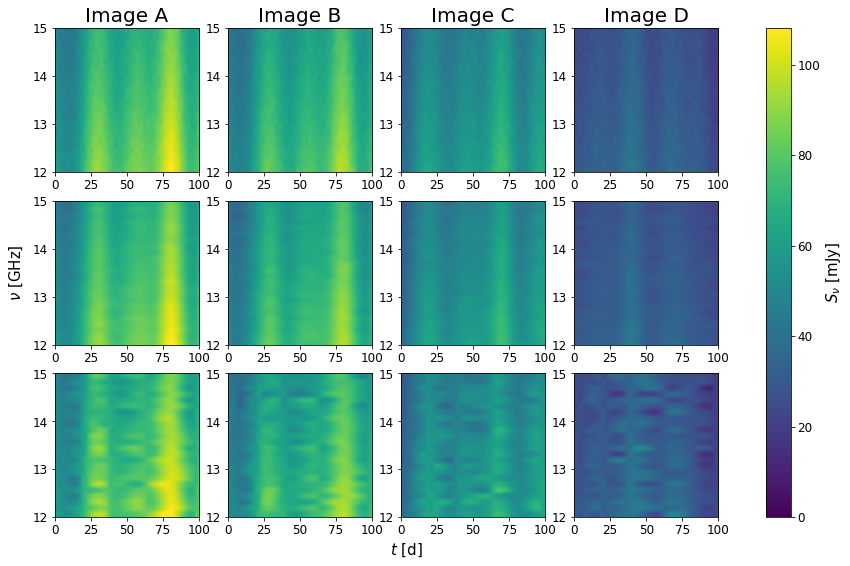

In [43]:
"""Plots of the interpolated data. Images are shown horizontally, measurement spacing is shown vertically. 
Bandwidth 2, time function 1."""

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)    # The big subplot
ax11 = fig.add_subplot(3,5,1)
ax12 = fig.add_subplot(3,5,2)
ax13 = fig.add_subplot(3,5,3)
ax14 = fig.add_subplot(3,5,4)
ax21 = fig.add_subplot(3,5,6)
ax22 = fig.add_subplot(3,5,7)
ax23 = fig.add_subplot(3,5,8)
ax24 = fig.add_subplot(3,5,9)
ax31 = fig.add_subplot(3,5,11)
ax32 = fig.add_subplot(3,5,12)
ax33 = fig.add_subplot(3,5,13)
ax34 = fig.add_subplot(3,5,14)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

m = 1
i = 0

Sv_max = np.max(data_dict["inter_sets"][m][:][i][:])

image = ax11.imshow(data_dict["inter_sets"][m][0][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax12.imshow(data_dict["inter_sets"][m][0][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax13.imshow(data_dict["inter_sets"][m][0][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax14.imshow(data_dict["inter_sets"][m][0][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax21.imshow(data_dict["inter_sets"][m][1][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax22.imshow(data_dict["inter_sets"][m][1][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax23.imshow(data_dict["inter_sets"][m][1][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax24.imshow(data_dict["inter_sets"][m][1][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax31.imshow(data_dict["inter_sets"][m][2][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax32.imshow(data_dict["inter_sets"][m][2][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax33.imshow(data_dict["inter_sets"][m][2][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax34.imshow(data_dict["inter_sets"][m][2][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])

ax11.set_aspect('auto')
ax12.set_aspect('auto')
ax13.set_aspect('auto')
ax14.set_aspect('auto')
ax21.set_aspect('auto')
ax22.set_aspect('auto')
ax23.set_aspect('auto')
ax24.set_aspect('auto')
ax31.set_aspect('auto')
ax32.set_aspect('auto')
ax33.set_aspect('auto')
ax34.set_aspect('auto')

# Set common labels
ax.set_xlabel(r'$t\ [\mathrm{d}]$')
ax.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')

ax11.set_title('Image A')
ax12.set_title('Image B')
ax13.set_title('Image C')
ax14.set_title('Image D')

# fig.colorbar(image, ax=ax)
fig.colorbar(image, ax=ax, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

plt.show()

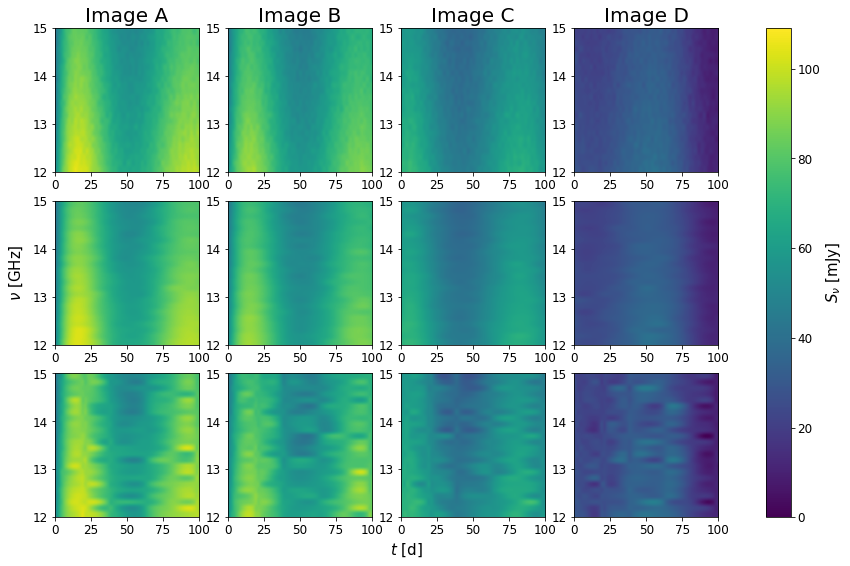

In [44]:
"""Plots of the interpolated data. Images are shown horizontally, measurement spacing is shown vertically. 
Bandwidth 2, time function 2."""

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)    # The big subplot
ax11 = fig.add_subplot(3,5,1)
ax12 = fig.add_subplot(3,5,2)
ax13 = fig.add_subplot(3,5,3)
ax14 = fig.add_subplot(3,5,4)
ax21 = fig.add_subplot(3,5,6)
ax22 = fig.add_subplot(3,5,7)
ax23 = fig.add_subplot(3,5,8)
ax24 = fig.add_subplot(3,5,9)
ax31 = fig.add_subplot(3,5,11)
ax32 = fig.add_subplot(3,5,12)
ax33 = fig.add_subplot(3,5,13)
ax34 = fig.add_subplot(3,5,14)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

m = 1
i = 1

Sv_max = np.max(data_dict["inter_sets"][m][:][i][:])

image = ax11.imshow(data_dict["inter_sets"][m][0][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax12.imshow(data_dict["inter_sets"][m][0][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax13.imshow(data_dict["inter_sets"][m][0][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax14.imshow(data_dict["inter_sets"][m][0][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax21.imshow(data_dict["inter_sets"][m][1][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax22.imshow(data_dict["inter_sets"][m][1][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax23.imshow(data_dict["inter_sets"][m][1][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax24.imshow(data_dict["inter_sets"][m][1][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax31.imshow(data_dict["inter_sets"][m][2][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax32.imshow(data_dict["inter_sets"][m][2][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax33.imshow(data_dict["inter_sets"][m][2][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax34.imshow(data_dict["inter_sets"][m][2][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])

ax11.set_aspect('auto')
ax12.set_aspect('auto')
ax13.set_aspect('auto')
ax14.set_aspect('auto')
ax21.set_aspect('auto')
ax22.set_aspect('auto')
ax23.set_aspect('auto')
ax24.set_aspect('auto')
ax31.set_aspect('auto')
ax32.set_aspect('auto')
ax33.set_aspect('auto')
ax34.set_aspect('auto')

# Set common labels
ax.set_xlabel(r'$t\ [\mathrm{d}]$')
ax.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')

ax11.set_title('Image A')
ax12.set_title('Image B')
ax13.set_title('Image C')
ax14.set_title('Image D')

# fig.colorbar(image, ax=ax)
fig.colorbar(image, ax=ax, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

plt.show()

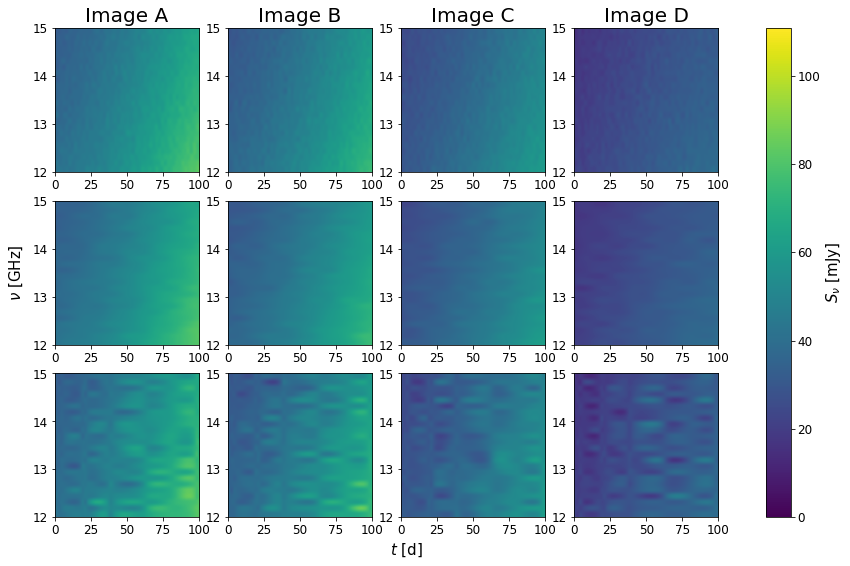

In [45]:
"""Plots of the interpolated data. Images are shown horizontally, measurement spacing is shown vertically. 
Bandwidth 2, time function 3."""

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)    # The big subplot
ax11 = fig.add_subplot(3,5,1)
ax12 = fig.add_subplot(3,5,2)
ax13 = fig.add_subplot(3,5,3)
ax14 = fig.add_subplot(3,5,4)
ax21 = fig.add_subplot(3,5,6)
ax22 = fig.add_subplot(3,5,7)
ax23 = fig.add_subplot(3,5,8)
ax24 = fig.add_subplot(3,5,9)
ax31 = fig.add_subplot(3,5,11)
ax32 = fig.add_subplot(3,5,12)
ax33 = fig.add_subplot(3,5,13)
ax34 = fig.add_subplot(3,5,14)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

m = 1
i = 2

Sv_max = np.max(data_dict["inter_sets"][m][:][i][:])

image = ax11.imshow(data_dict["inter_sets"][m][0][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax12.imshow(data_dict["inter_sets"][m][0][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax13.imshow(data_dict["inter_sets"][m][0][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax14.imshow(data_dict["inter_sets"][m][0][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax21.imshow(data_dict["inter_sets"][m][1][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax22.imshow(data_dict["inter_sets"][m][1][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax23.imshow(data_dict["inter_sets"][m][1][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax24.imshow(data_dict["inter_sets"][m][1][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax31.imshow(data_dict["inter_sets"][m][2][i][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax32.imshow(data_dict["inter_sets"][m][2][i][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax33.imshow(data_dict["inter_sets"][m][2][i][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])
ax34.imshow(data_dict["inter_sets"][m][2][i][3], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_sample,time_end_sample,bw_low,bw_up2])

ax11.set_aspect('auto')
ax12.set_aspect('auto')
ax13.set_aspect('auto')
ax14.set_aspect('auto')
ax21.set_aspect('auto')
ax22.set_aspect('auto')
ax23.set_aspect('auto')
ax24.set_aspect('auto')
ax31.set_aspect('auto')
ax32.set_aspect('auto')
ax33.set_aspect('auto')
ax34.set_aspect('auto')

# Set common labels
ax.set_xlabel(r'$t\ [\mathrm{d}]$')
ax.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')

ax11.set_title('Image A')
ax12.set_title('Image B')
ax13.set_title('Image C')
ax14.set_title('Image D')

# fig.colorbar(image, ax=ax)
fig.colorbar(image, ax=ax, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

plt.show()

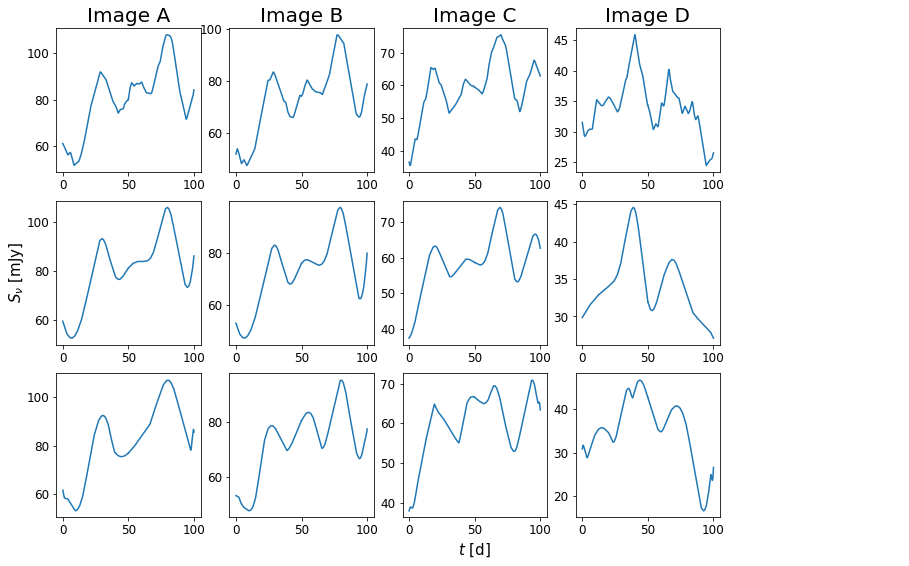

In [143]:
"""Plots of the interpolated data. Images are shown horizontally, measurement spacing is shown vertically. 
Bandwidth 2, time function 1."""

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)    # The big subplot
ax11 = fig.add_subplot(3,5,1)
ax12 = fig.add_subplot(3,5,2)
ax13 = fig.add_subplot(3,5,3)
ax14 = fig.add_subplot(3,5,4)
ax21 = fig.add_subplot(3,5,6)
ax22 = fig.add_subplot(3,5,7)
ax23 = fig.add_subplot(3,5,8)
ax24 = fig.add_subplot(3,5,9)
ax31 = fig.add_subplot(3,5,11)
ax32 = fig.add_subplot(3,5,12)
ax33 = fig.add_subplot(3,5,13)
ax34 = fig.add_subplot(3,5,14)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

m = 2
i = 0

Sv_max = np.max(data_dict["inter_sets"][m][:][i][:])

image = ax11.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][0][i][0][0])
ax12.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][0][i][1][0])
ax13.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][0][i][2][0])
ax14.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][0][i][3][0])
ax21.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][1][i][0][0])
ax22.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][1][i][1][0])
ax23.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][1][i][2][0])
ax24.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][1][i][3][0])
ax31.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][2][i][0][0])
ax32.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][2][i][1][0])
ax33.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][2][i][2][0])
ax34.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][2][i][3][0])

ax11.set_aspect('auto')
ax12.set_aspect('auto')
ax13.set_aspect('auto')
ax14.set_aspect('auto')
ax21.set_aspect('auto')
ax22.set_aspect('auto')
ax23.set_aspect('auto')
ax24.set_aspect('auto')
ax31.set_aspect('auto')
ax32.set_aspect('auto')
ax33.set_aspect('auto')
ax34.set_aspect('auto')

# Set common labels
ax.set_xlabel(r'$t\ [\mathrm{d}]$')
ax.set_ylabel(r'$S_{\nu}\ [\mathrm{mJy}]$')

ax11.set_title('Image A')
ax12.set_title('Image B')
ax13.set_title('Image C')
ax14.set_title('Image D')

# fig.colorbar(image, ax=ax)
# fig.colorbar(image, ax=ax, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

plt.show()

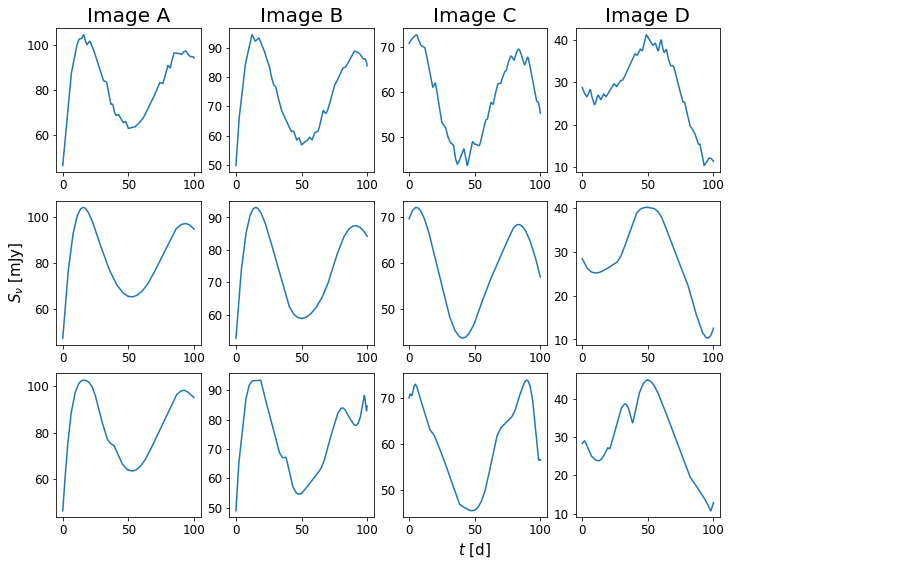

In [144]:
"""Plots of the interpolated data. Images are shown horizontally, measurement spacing is shown vertically. 
Bandwidth 2, time function 1."""

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)    # The big subplot
ax11 = fig.add_subplot(3,5,1)
ax12 = fig.add_subplot(3,5,2)
ax13 = fig.add_subplot(3,5,3)
ax14 = fig.add_subplot(3,5,4)
ax21 = fig.add_subplot(3,5,6)
ax22 = fig.add_subplot(3,5,7)
ax23 = fig.add_subplot(3,5,8)
ax24 = fig.add_subplot(3,5,9)
ax31 = fig.add_subplot(3,5,11)
ax32 = fig.add_subplot(3,5,12)
ax33 = fig.add_subplot(3,5,13)
ax34 = fig.add_subplot(3,5,14)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

m = 2
i = 1

Sv_max = np.max(data_dict["inter_sets"][m][:][i][:])

image = ax11.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][0][i][0][0])
ax12.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][0][i][1][0])
ax13.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][0][i][2][0])
ax14.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][0][i][3][0])
ax21.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][1][i][0][0])
ax22.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][1][i][1][0])
ax23.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][1][i][2][0])
ax24.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][1][i][3][0])
ax31.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][2][i][0][0])
ax32.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][2][i][1][0])
ax33.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][2][i][2][0])
ax34.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][2][i][3][0])

ax11.set_aspect('auto')
ax12.set_aspect('auto')
ax13.set_aspect('auto')
ax14.set_aspect('auto')
ax21.set_aspect('auto')
ax22.set_aspect('auto')
ax23.set_aspect('auto')
ax24.set_aspect('auto')
ax31.set_aspect('auto')
ax32.set_aspect('auto')
ax33.set_aspect('auto')
ax34.set_aspect('auto')

# Set common labels
ax.set_xlabel(r'$t\ [\mathrm{d}]$')
ax.set_ylabel(r'$S_{\nu}\ [\mathrm{mJy}]$')

ax11.set_title('Image A')
ax12.set_title('Image B')
ax13.set_title('Image C')
ax14.set_title('Image D')

# fig.colorbar(image, ax=ax)
# fig.colorbar(image, ax=ax, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

plt.show()

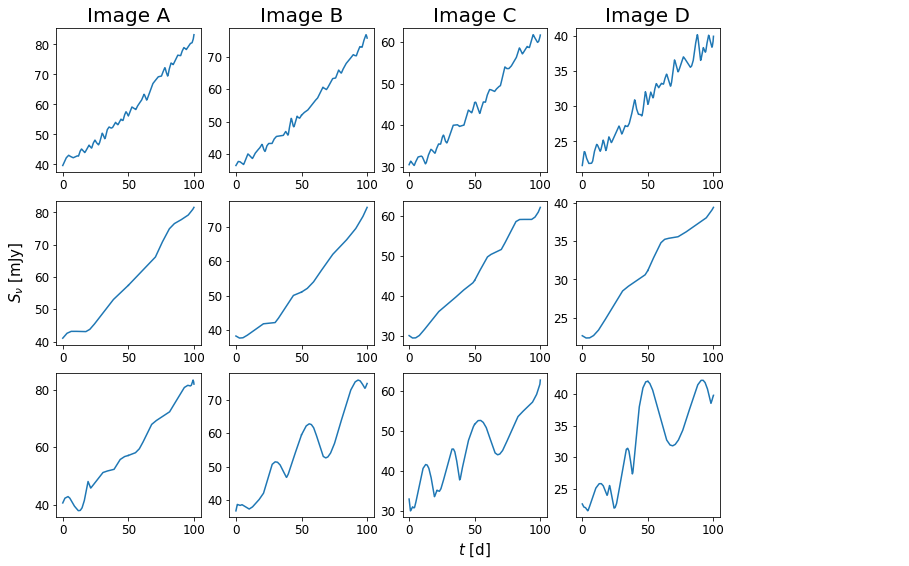

In [145]:
"""Plots of the interpolated data. Images are shown horizontally, measurement spacing is shown vertically. 
Bandwidth 2, time function 1."""

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)    # The big subplot
ax11 = fig.add_subplot(3,5,1)
ax12 = fig.add_subplot(3,5,2)
ax13 = fig.add_subplot(3,5,3)
ax14 = fig.add_subplot(3,5,4)
ax21 = fig.add_subplot(3,5,6)
ax22 = fig.add_subplot(3,5,7)
ax23 = fig.add_subplot(3,5,8)
ax24 = fig.add_subplot(3,5,9)
ax31 = fig.add_subplot(3,5,11)
ax32 = fig.add_subplot(3,5,12)
ax33 = fig.add_subplot(3,5,13)
ax34 = fig.add_subplot(3,5,14)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

m = 2
i = 2

Sv_max = np.max(data_dict["inter_sets"][m][:][i][:])

image = ax11.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][0][i][0][0])
ax12.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][0][i][1][0])
ax13.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][0][i][2][0])
ax14.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][0][i][3][0])
ax21.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][1][i][0][0])
ax22.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][1][i][1][0])
ax23.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][1][i][2][0])
ax24.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][1][i][3][0])
ax31.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][2][i][0][0])
ax32.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][2][i][1][0])
ax33.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][2][i][2][0])
ax34.plot(data_dict["full_times"][i]/step_size, data_dict["inter_sets"][m][2][i][3][0])

ax11.set_aspect('auto')
ax12.set_aspect('auto')
ax13.set_aspect('auto')
ax14.set_aspect('auto')
ax21.set_aspect('auto')
ax22.set_aspect('auto')
ax23.set_aspect('auto')
ax24.set_aspect('auto')
ax31.set_aspect('auto')
ax32.set_aspect('auto')
ax33.set_aspect('auto')
ax34.set_aspect('auto')

# Set common labels
ax.set_xlabel(r'$t\ [\mathrm{d}]$')
ax.set_ylabel(r'$S_{\nu}\ [\mathrm{mJy}]$')

ax11.set_title('Image A')
ax12.set_title('Image B')
ax13.set_title('Image C')
ax14.set_title('Image D')

# fig.colorbar(image, ax=ax)
# fig.colorbar(image, ax=ax, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

plt.show()

## Delays

In [49]:
color_lines = [Line2D([0], [0], color='k', lw=4),
               Line2D([0], [0], color='r', lw=4),
               Line2D([0], [0], color='g', lw=4),
               Line2D([0], [0], color='b', lw=4),
               Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=10),
               Line2D([0], [0], marker='X', color='w', markerfacecolor='k', markersize=10),
               Line2D([0], [0], marker='^', color='w', markerfacecolor='k', markersize=10)]

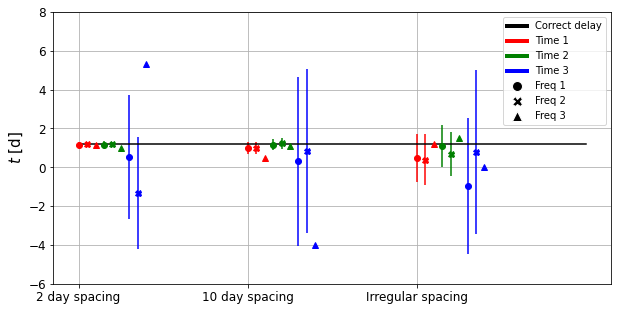

In [50]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot([1,4], [1.2,1.2], 'k-')

# [Freq,Meas,Time]
frame.errorbar(x=1.00, y=data_dict["delay_means"][0][0][0][0]/step_size, yerr=data_dict["delay_stds"][0][0][0][0]/step_size, fmt='ro')
frame.errorbar(x=1.15, y=data_dict["delay_means"][0][0][1][0]/step_size, yerr=data_dict["delay_stds"][0][0][1][0]/step_size, fmt='go')
frame.errorbar(x=1.30, y=data_dict["delay_means"][0][0][2][0]/step_size, yerr=data_dict["delay_stds"][0][0][2][0]/step_size, fmt='bo')
frame.errorbar(x=2.00, y=data_dict["delay_means"][0][1][0][0]/step_size, yerr=data_dict["delay_stds"][0][1][0][0]/step_size, fmt='ro')
frame.errorbar(x=2.15, y=data_dict["delay_means"][0][1][1][0]/step_size, yerr=data_dict["delay_stds"][0][1][1][0]/step_size, fmt='go')
frame.errorbar(x=2.30, y=data_dict["delay_means"][0][1][2][0]/step_size, yerr=data_dict["delay_stds"][0][1][2][0]/step_size, fmt='bo')
frame.errorbar(x=3.00, y=data_dict["delay_means"][0][2][0][0]/step_size, yerr=data_dict["delay_stds"][0][2][0][0]/step_size, fmt='ro')
frame.errorbar(x=3.15, y=data_dict["delay_means"][0][2][1][0]/step_size, yerr=data_dict["delay_stds"][0][2][1][0]/step_size, fmt='go')
frame.errorbar(x=3.30, y=data_dict["delay_means"][0][2][2][0]/step_size, yerr=data_dict["delay_stds"][0][2][2][0]/step_size, fmt='bo')

frame.errorbar(x=1.05, y=data_dict["delay_means"][1][0][0][0]/step_size, yerr=data_dict["delay_stds"][1][0][0][0]/step_size, fmt='rX')
frame.errorbar(x=1.20, y=data_dict["delay_means"][1][0][1][0]/step_size, yerr=data_dict["delay_stds"][1][0][1][0]/step_size, fmt='gX')
frame.errorbar(x=1.35, y=data_dict["delay_means"][1][0][2][0]/step_size, yerr=data_dict["delay_stds"][1][0][2][0]/step_size, fmt='bX')
frame.errorbar(x=2.05, y=data_dict["delay_means"][1][1][0][0]/step_size, yerr=data_dict["delay_stds"][1][1][0][0]/step_size, fmt='rX')
frame.errorbar(x=2.20, y=data_dict["delay_means"][1][1][1][0]/step_size, yerr=data_dict["delay_stds"][1][1][1][0]/step_size, fmt='gX')
frame.errorbar(x=2.35, y=data_dict["delay_means"][1][1][2][0]/step_size, yerr=data_dict["delay_stds"][1][1][2][0]/step_size, fmt='bX')
frame.errorbar(x=3.05, y=data_dict["delay_means"][1][2][0][0]/step_size, yerr=data_dict["delay_stds"][1][2][0][0]/step_size, fmt='rX')
frame.errorbar(x=3.20, y=data_dict["delay_means"][1][2][1][0]/step_size, yerr=data_dict["delay_stds"][1][2][1][0]/step_size, fmt='gX')
frame.errorbar(x=3.35, y=data_dict["delay_means"][1][2][2][0]/step_size, yerr=data_dict["delay_stds"][1][2][2][0]/step_size, fmt='bX')

frame.errorbar(x=1.10, y=data_dict["delay_means"][2][0][0][0]/step_size, yerr=data_dict["delay_stds"][2][0][0][0]/step_size, fmt='r^')
frame.errorbar(x=1.25, y=data_dict["delay_means"][2][0][1][0]/step_size, yerr=data_dict["delay_stds"][2][0][1][0]/step_size, fmt='g^')
frame.errorbar(x=1.40, y=data_dict["delay_means"][2][0][2][0]/step_size, yerr=data_dict["delay_stds"][2][0][2][0]/step_size, fmt='b^')
frame.errorbar(x=2.10, y=data_dict["delay_means"][2][1][0][0]/step_size, yerr=data_dict["delay_stds"][2][1][0][0]/step_size, fmt='r^')
frame.errorbar(x=2.25, y=data_dict["delay_means"][2][1][1][0]/step_size, yerr=data_dict["delay_stds"][2][1][1][0]/step_size, fmt='g^')
frame.errorbar(x=2.40, y=data_dict["delay_means"][2][1][2][0]/step_size, yerr=data_dict["delay_stds"][2][1][2][0]/step_size, fmt='b^')
frame.errorbar(x=3.10, y=data_dict["delay_means"][2][2][0][0]/step_size, yerr=data_dict["delay_stds"][2][2][0][0]/step_size, fmt='r^')
frame.errorbar(x=3.25, y=data_dict["delay_means"][2][2][1][0]/step_size, yerr=data_dict["delay_stds"][2][2][1][0]/step_size, fmt='g^')
frame.errorbar(x=3.40, y=data_dict["delay_means"][2][2][2][0]/step_size, yerr=data_dict["delay_stds"][2][2][2][0]/step_size, fmt='b^')

frame.set_ylabel(r'$t\ [\mathrm{d}]$')
frame.set_aspect('auto')
frame.grid()
frame.legend(color_lines, ['Correct delay', 'Time 1', 'Time 2', 'Time 3', 'Freq 1', 'Freq 2', 'Freq 3'], loc=1)
frame.set_ylim(-6,8)
plt.xticks([1,2,3],['2 day spacing','10 day spacing','Irregular spacing'])

plt.show()

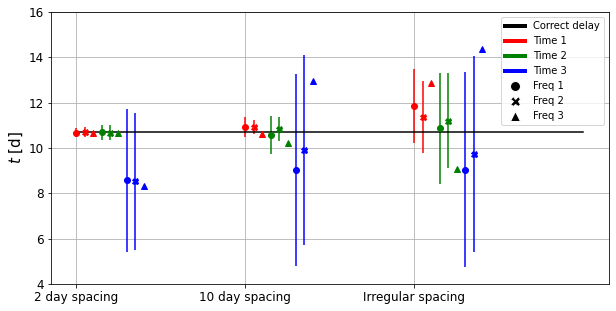

In [51]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot([1,4], [10.72,10.72], 'k-')

# [Freq,Meas,Time]
frame.errorbar(x=1.00, y=data_dict["delay_means"][0][0][0][1]/step_size, yerr=data_dict["delay_stds"][0][0][0][1]/step_size, fmt='ro')
frame.errorbar(x=1.15, y=data_dict["delay_means"][0][0][1][1]/step_size, yerr=data_dict["delay_stds"][0][0][1][1]/step_size, fmt='go')
frame.errorbar(x=1.30, y=data_dict["delay_means"][0][0][2][1]/step_size, yerr=data_dict["delay_stds"][0][0][2][1]/step_size, fmt='bo')
frame.errorbar(x=2.00, y=data_dict["delay_means"][0][1][0][1]/step_size, yerr=data_dict["delay_stds"][0][1][0][1]/step_size, fmt='ro')
frame.errorbar(x=2.15, y=data_dict["delay_means"][0][1][1][1]/step_size, yerr=data_dict["delay_stds"][0][1][1][1]/step_size, fmt='go')
frame.errorbar(x=2.30, y=data_dict["delay_means"][0][1][2][1]/step_size, yerr=data_dict["delay_stds"][0][1][2][1]/step_size, fmt='bo')
frame.errorbar(x=3.00, y=data_dict["delay_means"][0][2][0][1]/step_size, yerr=data_dict["delay_stds"][0][2][0][1]/step_size, fmt='ro')
frame.errorbar(x=3.15, y=data_dict["delay_means"][0][2][1][1]/step_size, yerr=data_dict["delay_stds"][0][2][1][1]/step_size, fmt='go')
frame.errorbar(x=3.30, y=data_dict["delay_means"][0][2][2][1]/step_size, yerr=data_dict["delay_stds"][0][2][2][1]/step_size, fmt='bo')

frame.errorbar(x=1.05, y=data_dict["delay_means"][1][0][0][1]/step_size, yerr=data_dict["delay_stds"][1][0][0][1]/step_size, fmt='rX')
frame.errorbar(x=1.20, y=data_dict["delay_means"][1][0][1][1]/step_size, yerr=data_dict["delay_stds"][1][0][1][1]/step_size, fmt='gX')
frame.errorbar(x=1.35, y=data_dict["delay_means"][1][0][2][1]/step_size, yerr=data_dict["delay_stds"][1][0][2][1]/step_size, fmt='bX')
frame.errorbar(x=2.05, y=data_dict["delay_means"][1][1][0][1]/step_size, yerr=data_dict["delay_stds"][1][1][0][1]/step_size, fmt='rX')
frame.errorbar(x=2.20, y=data_dict["delay_means"][1][1][1][1]/step_size, yerr=data_dict["delay_stds"][1][1][1][1]/step_size, fmt='gX')
frame.errorbar(x=2.35, y=data_dict["delay_means"][1][1][2][1]/step_size, yerr=data_dict["delay_stds"][1][1][2][1]/step_size, fmt='bX')
frame.errorbar(x=3.05, y=data_dict["delay_means"][1][2][0][1]/step_size, yerr=data_dict["delay_stds"][1][2][0][1]/step_size, fmt='rX')
frame.errorbar(x=3.20, y=data_dict["delay_means"][1][2][1][1]/step_size, yerr=data_dict["delay_stds"][1][2][1][1]/step_size, fmt='gX')
frame.errorbar(x=3.35, y=data_dict["delay_means"][1][2][2][1]/step_size, yerr=data_dict["delay_stds"][1][2][2][1]/step_size, fmt='bX')

frame.errorbar(x=1.10, y=data_dict["delay_means"][2][0][0][1]/step_size, yerr=data_dict["delay_stds"][2][0][0][1]/step_size, fmt='r^')
frame.errorbar(x=1.25, y=data_dict["delay_means"][2][0][1][1]/step_size, yerr=data_dict["delay_stds"][2][0][1][1]/step_size, fmt='g^')
frame.errorbar(x=1.40, y=data_dict["delay_means"][2][0][2][1]/step_size, yerr=data_dict["delay_stds"][2][0][2][1]/step_size, fmt='b^')
frame.errorbar(x=2.10, y=data_dict["delay_means"][2][1][0][1]/step_size, yerr=data_dict["delay_stds"][2][1][0][1]/step_size, fmt='r^')
frame.errorbar(x=2.25, y=data_dict["delay_means"][2][1][1][1]/step_size, yerr=data_dict["delay_stds"][2][1][1][1]/step_size, fmt='g^')
frame.errorbar(x=2.40, y=data_dict["delay_means"][2][1][2][1]/step_size, yerr=data_dict["delay_stds"][2][1][2][1]/step_size, fmt='b^')
frame.errorbar(x=3.10, y=data_dict["delay_means"][2][2][0][1]/step_size, yerr=data_dict["delay_stds"][2][2][0][1]/step_size, fmt='r^')
frame.errorbar(x=3.25, y=data_dict["delay_means"][2][2][1][1]/step_size, yerr=data_dict["delay_stds"][2][2][1][1]/step_size, fmt='g^')
frame.errorbar(x=3.40, y=data_dict["delay_means"][2][2][2][1]/step_size, yerr=data_dict["delay_stds"][2][2][2][1]/step_size, fmt='b^')

frame.set_ylabel(r'$t\ [\mathrm{d}]$')
frame.set_aspect('auto')
frame.grid()
frame.legend(color_lines, ['Correct delay', 'Time 1', 'Time 2', 'Time 3', 'Freq 1', 'Freq 2', 'Freq 3'], loc=1)
frame.set_ylim(4,16)
plt.xticks([1,2,3],['2 day spacing','10 day spacing','Irregular spacing'])

plt.show()

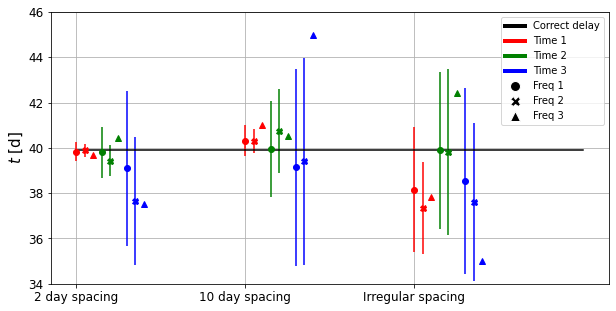

In [52]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot([1,4], [39.899,39.899], 'k-')

# [Freq,Meas,Time]
frame.errorbar(x=1.00, y=data_dict["delay_means"][0][0][0][2]/step_size, yerr=data_dict["delay_stds"][0][0][0][2]/step_size, fmt='ro')
frame.errorbar(x=1.15, y=data_dict["delay_means"][0][0][1][2]/step_size, yerr=data_dict["delay_stds"][0][0][1][2]/step_size, fmt='go')
frame.errorbar(x=1.30, y=data_dict["delay_means"][0][0][2][2]/step_size, yerr=data_dict["delay_stds"][0][0][2][2]/step_size, fmt='bo')
frame.errorbar(x=2.00, y=data_dict["delay_means"][0][1][0][2]/step_size, yerr=data_dict["delay_stds"][0][1][0][2]/step_size, fmt='ro')
frame.errorbar(x=2.15, y=data_dict["delay_means"][0][1][1][2]/step_size, yerr=data_dict["delay_stds"][0][1][1][2]/step_size, fmt='go')
frame.errorbar(x=2.30, y=data_dict["delay_means"][0][1][2][2]/step_size, yerr=data_dict["delay_stds"][0][1][2][2]/step_size, fmt='bo')
frame.errorbar(x=3.00, y=data_dict["delay_means"][0][2][0][2]/step_size, yerr=data_dict["delay_stds"][0][2][0][2]/step_size, fmt='ro')
frame.errorbar(x=3.15, y=data_dict["delay_means"][0][2][1][2]/step_size, yerr=data_dict["delay_stds"][0][2][1][2]/step_size, fmt='go')
frame.errorbar(x=3.30, y=data_dict["delay_means"][0][2][2][2]/step_size, yerr=data_dict["delay_stds"][0][2][2][2]/step_size, fmt='bo')

frame.errorbar(x=1.05, y=data_dict["delay_means"][1][0][0][2]/step_size, yerr=data_dict["delay_stds"][1][0][0][2]/step_size, fmt='rX')
frame.errorbar(x=1.20, y=data_dict["delay_means"][1][0][1][2]/step_size, yerr=data_dict["delay_stds"][1][0][1][2]/step_size, fmt='gX')
frame.errorbar(x=1.35, y=data_dict["delay_means"][1][0][2][2]/step_size, yerr=data_dict["delay_stds"][1][0][2][2]/step_size, fmt='bX')
frame.errorbar(x=2.05, y=data_dict["delay_means"][1][1][0][2]/step_size, yerr=data_dict["delay_stds"][1][1][0][2]/step_size, fmt='rX')
frame.errorbar(x=2.20, y=data_dict["delay_means"][1][1][1][2]/step_size, yerr=data_dict["delay_stds"][1][1][1][2]/step_size, fmt='gX')
frame.errorbar(x=2.35, y=data_dict["delay_means"][1][1][2][2]/step_size, yerr=data_dict["delay_stds"][1][1][2][2]/step_size, fmt='bX')
frame.errorbar(x=3.05, y=data_dict["delay_means"][1][2][0][2]/step_size, yerr=data_dict["delay_stds"][1][2][0][2]/step_size, fmt='rX')
frame.errorbar(x=3.20, y=data_dict["delay_means"][1][2][1][2]/step_size, yerr=data_dict["delay_stds"][1][2][1][2]/step_size, fmt='gX')
frame.errorbar(x=3.35, y=data_dict["delay_means"][1][2][2][2]/step_size, yerr=data_dict["delay_stds"][1][2][2][2]/step_size, fmt='bX')

frame.errorbar(x=1.10, y=data_dict["delay_means"][2][0][0][2]/step_size, yerr=data_dict["delay_stds"][2][0][0][2]/step_size, fmt='r^')
frame.errorbar(x=1.25, y=data_dict["delay_means"][2][0][1][2]/step_size, yerr=data_dict["delay_stds"][2][0][1][2]/step_size, fmt='g^')
frame.errorbar(x=1.40, y=data_dict["delay_means"][2][0][2][2]/step_size, yerr=data_dict["delay_stds"][2][0][2][2]/step_size, fmt='b^')
frame.errorbar(x=2.10, y=data_dict["delay_means"][2][1][0][2]/step_size, yerr=data_dict["delay_stds"][2][1][0][2]/step_size, fmt='r^')
frame.errorbar(x=2.25, y=data_dict["delay_means"][2][1][1][2]/step_size, yerr=data_dict["delay_stds"][2][1][1][2]/step_size, fmt='g^')
frame.errorbar(x=2.40, y=data_dict["delay_means"][2][1][2][2]/step_size, yerr=data_dict["delay_stds"][2][1][2][2]/step_size, fmt='b^')
frame.errorbar(x=3.10, y=data_dict["delay_means"][2][2][0][2]/step_size, yerr=data_dict["delay_stds"][2][2][0][2]/step_size, fmt='r^')
frame.errorbar(x=3.25, y=data_dict["delay_means"][2][2][1][2]/step_size, yerr=data_dict["delay_stds"][2][2][1][2]/step_size, fmt='g^')
frame.errorbar(x=3.40, y=data_dict["delay_means"][2][2][2][2]/step_size, yerr=data_dict["delay_stds"][2][2][2][2]/step_size, fmt='b^')

frame.set_ylabel(r'$t\ [\mathrm{d}]$')
frame.set_aspect('auto')
frame.grid()
frame.legend(color_lines, ['Correct delay', 'Time 1', 'Time 2', 'Time 3', 'Freq 1', 'Freq 2', 'Freq 3'], loc=1)
frame.set_ylim(34,46)
plt.xticks([1,2,3],['2 day spacing','10 day spacing','Irregular spacing'])

plt.show()

## Flux ratios

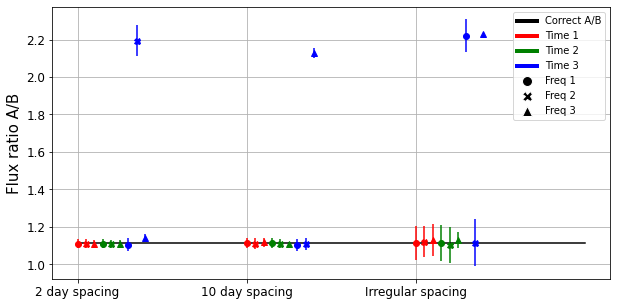

In [188]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot([1,4], [1/0.9,1/0.9], 'k-')

# [Freq,Meas,Time]
frame.errorbar(x=1.00, y=data_dict["flux_ratio_means"][0][0][0][0], yerr=data_dict["flux_ratio_stds"][0][0][0][0], fmt='ro')
frame.errorbar(x=1.15, y=data_dict["flux_ratio_means"][0][0][1][0], yerr=data_dict["flux_ratio_stds"][0][0][1][0], fmt='go')
frame.errorbar(x=1.30, y=data_dict["flux_ratio_means"][0][0][2][0], yerr=data_dict["flux_ratio_stds"][0][0][2][0], fmt='bo')
frame.errorbar(x=2.00, y=data_dict["flux_ratio_means"][0][1][0][0], yerr=data_dict["flux_ratio_stds"][0][1][0][0], fmt='ro')
frame.errorbar(x=2.15, y=data_dict["flux_ratio_means"][0][1][1][0], yerr=data_dict["flux_ratio_stds"][0][1][1][0], fmt='go')
frame.errorbar(x=2.30, y=data_dict["flux_ratio_means"][0][1][2][0], yerr=data_dict["flux_ratio_stds"][0][1][2][0], fmt='bo')
frame.errorbar(x=3.00, y=data_dict["flux_ratio_means"][0][2][0][0], yerr=data_dict["flux_ratio_stds"][0][2][0][0], fmt='ro')
frame.errorbar(x=3.15, y=data_dict["flux_ratio_means"][0][2][1][0], yerr=data_dict["flux_ratio_stds"][0][2][1][0], fmt='go')
frame.errorbar(x=3.30, y=data_dict["flux_ratio_means"][0][2][2][0], yerr=data_dict["flux_ratio_stds"][0][2][2][0], fmt='bo')

frame.errorbar(x=1.05, y=data_dict["flux_ratio_means"][1][0][0][0], yerr=data_dict["flux_ratio_stds"][1][0][0][0], fmt='rX')
frame.errorbar(x=1.20, y=data_dict["flux_ratio_means"][1][0][1][0], yerr=data_dict["flux_ratio_stds"][1][0][1][0], fmt='gX')
frame.errorbar(x=1.35, y=data_dict["flux_ratio_means"][1][0][2][0], yerr=data_dict["flux_ratio_stds"][1][0][2][0], fmt='bX')
frame.errorbar(x=2.05, y=data_dict["flux_ratio_means"][1][1][0][0], yerr=data_dict["flux_ratio_stds"][1][1][0][0], fmt='rX')
frame.errorbar(x=2.20, y=data_dict["flux_ratio_means"][1][1][1][0], yerr=data_dict["flux_ratio_stds"][1][1][1][0], fmt='gX')
frame.errorbar(x=2.35, y=data_dict["flux_ratio_means"][1][1][2][0], yerr=data_dict["flux_ratio_stds"][1][1][2][0], fmt='bX')
frame.errorbar(x=3.05, y=data_dict["flux_ratio_means"][1][2][0][0], yerr=data_dict["flux_ratio_stds"][1][2][0][0], fmt='rX')
frame.errorbar(x=3.20, y=data_dict["flux_ratio_means"][1][2][1][0], yerr=data_dict["flux_ratio_stds"][1][2][1][0], fmt='gX')
frame.errorbar(x=3.35, y=data_dict["flux_ratio_means"][1][2][2][0], yerr=data_dict["flux_ratio_stds"][1][2][2][0], fmt='bX')

frame.errorbar(x=1.10, y=data_dict["flux_ratio_means"][2][0][0][0], yerr=data_dict["flux_ratio_stds"][2][0][0][0], fmt='r^')
frame.errorbar(x=1.25, y=data_dict["flux_ratio_means"][2][0][1][0], yerr=data_dict["flux_ratio_stds"][2][0][1][0], fmt='g^')
frame.errorbar(x=1.40, y=data_dict["flux_ratio_means"][2][0][2][0], yerr=data_dict["flux_ratio_stds"][2][0][2][0], fmt='b^')
frame.errorbar(x=2.10, y=data_dict["flux_ratio_means"][2][1][0][0], yerr=data_dict["flux_ratio_stds"][2][1][0][0], fmt='r^')
frame.errorbar(x=2.25, y=data_dict["flux_ratio_means"][2][1][1][0], yerr=data_dict["flux_ratio_stds"][2][1][1][0], fmt='g^')
frame.errorbar(x=2.40, y=data_dict["flux_ratio_means"][2][1][2][0], yerr=data_dict["flux_ratio_stds"][2][1][2][0], fmt='b^')
frame.errorbar(x=3.10, y=data_dict["flux_ratio_means"][2][2][0][0], yerr=data_dict["flux_ratio_stds"][2][2][0][0], fmt='r^')
frame.errorbar(x=3.25, y=data_dict["flux_ratio_means"][2][2][1][0], yerr=data_dict["flux_ratio_stds"][2][2][1][0], fmt='g^')
frame.errorbar(x=3.40, y=data_dict["flux_ratio_means"][2][2][2][0], yerr=data_dict["flux_ratio_stds"][2][2][2][0], fmt='b^')

frame.set_ylabel(r'Flux ratio A/B')
frame.set_aspect('auto')
frame.grid()
frame.legend(color_lines, ['Correct A/B', 'Time 1', 'Time 2', 'Time 3', 'Freq 1', 'Freq 2', 'Freq 3'], loc=1)
plt.xticks([1,2,3],['2 day spacing','10 day spacing','Irregular spacing'])

plt.show()

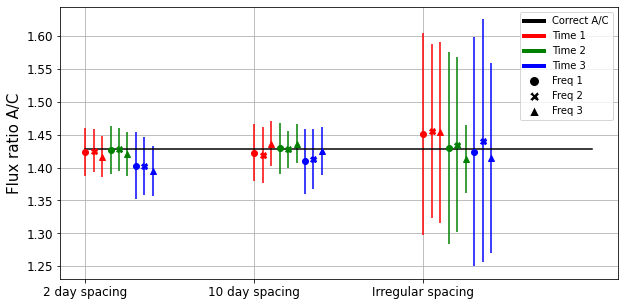

In [189]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot([1,4], [1/0.7,1/0.7], 'k-')

# [Freq,Meas,Time]
frame.errorbar(x=1.00, y=data_dict["flux_ratio_means"][0][0][0][1], yerr=data_dict["flux_ratio_stds"][0][0][0][1], fmt='ro')
frame.errorbar(x=1.15, y=data_dict["flux_ratio_means"][0][0][1][1], yerr=data_dict["flux_ratio_stds"][0][0][1][1], fmt='go')
frame.errorbar(x=1.30, y=data_dict["flux_ratio_means"][0][0][2][1], yerr=data_dict["flux_ratio_stds"][0][0][2][1], fmt='bo')
frame.errorbar(x=2.00, y=data_dict["flux_ratio_means"][0][1][0][1], yerr=data_dict["flux_ratio_stds"][0][1][0][1], fmt='ro')
frame.errorbar(x=2.15, y=data_dict["flux_ratio_means"][0][1][1][1], yerr=data_dict["flux_ratio_stds"][0][1][1][1], fmt='go')
frame.errorbar(x=2.30, y=data_dict["flux_ratio_means"][0][1][2][1], yerr=data_dict["flux_ratio_stds"][0][1][2][1], fmt='bo')
frame.errorbar(x=3.00, y=data_dict["flux_ratio_means"][0][2][0][1], yerr=data_dict["flux_ratio_stds"][0][2][0][1], fmt='ro')
frame.errorbar(x=3.15, y=data_dict["flux_ratio_means"][0][2][1][1], yerr=data_dict["flux_ratio_stds"][0][2][1][1], fmt='go')
frame.errorbar(x=3.30, y=data_dict["flux_ratio_means"][0][2][2][1], yerr=data_dict["flux_ratio_stds"][0][2][2][1], fmt='bo')

frame.errorbar(x=1.05, y=data_dict["flux_ratio_means"][1][0][0][1], yerr=data_dict["flux_ratio_stds"][1][0][0][1], fmt='rX')
frame.errorbar(x=1.20, y=data_dict["flux_ratio_means"][1][0][1][1], yerr=data_dict["flux_ratio_stds"][1][0][1][1], fmt='gX')
frame.errorbar(x=1.35, y=data_dict["flux_ratio_means"][1][0][2][1], yerr=data_dict["flux_ratio_stds"][1][0][2][1], fmt='bX')
frame.errorbar(x=2.05, y=data_dict["flux_ratio_means"][1][1][0][1], yerr=data_dict["flux_ratio_stds"][1][1][0][1], fmt='rX')
frame.errorbar(x=2.20, y=data_dict["flux_ratio_means"][1][1][1][1], yerr=data_dict["flux_ratio_stds"][1][1][1][1], fmt='gX')
frame.errorbar(x=2.35, y=data_dict["flux_ratio_means"][1][1][2][1], yerr=data_dict["flux_ratio_stds"][1][1][2][1], fmt='bX')
frame.errorbar(x=3.05, y=data_dict["flux_ratio_means"][1][2][0][1], yerr=data_dict["flux_ratio_stds"][1][2][0][1], fmt='rX')
frame.errorbar(x=3.20, y=data_dict["flux_ratio_means"][1][2][1][1], yerr=data_dict["flux_ratio_stds"][1][2][1][1], fmt='gX')
frame.errorbar(x=3.35, y=data_dict["flux_ratio_means"][1][2][2][1], yerr=data_dict["flux_ratio_stds"][1][2][2][1], fmt='bX')

frame.errorbar(x=1.10, y=data_dict["flux_ratio_means"][2][0][0][1], yerr=data_dict["flux_ratio_stds"][2][0][0][1], fmt='r^')
frame.errorbar(x=1.25, y=data_dict["flux_ratio_means"][2][0][1][1], yerr=data_dict["flux_ratio_stds"][2][0][1][1], fmt='g^')
frame.errorbar(x=1.40, y=data_dict["flux_ratio_means"][2][0][2][1], yerr=data_dict["flux_ratio_stds"][2][0][2][1], fmt='b^')
frame.errorbar(x=2.10, y=data_dict["flux_ratio_means"][2][1][0][1], yerr=data_dict["flux_ratio_stds"][2][1][0][1], fmt='r^')
frame.errorbar(x=2.25, y=data_dict["flux_ratio_means"][2][1][1][1], yerr=data_dict["flux_ratio_stds"][2][1][1][1], fmt='g^')
frame.errorbar(x=2.40, y=data_dict["flux_ratio_means"][2][1][2][1], yerr=data_dict["flux_ratio_stds"][2][1][2][1], fmt='b^')
frame.errorbar(x=3.10, y=data_dict["flux_ratio_means"][2][2][0][1], yerr=data_dict["flux_ratio_stds"][2][2][0][1], fmt='r^')
frame.errorbar(x=3.25, y=data_dict["flux_ratio_means"][2][2][1][1], yerr=data_dict["flux_ratio_stds"][2][2][1][1], fmt='g^')
frame.errorbar(x=3.40, y=data_dict["flux_ratio_means"][2][2][2][1], yerr=data_dict["flux_ratio_stds"][2][2][2][1], fmt='b^')

frame.set_ylabel(r'Flux ratio A/C')
frame.set_aspect('auto')
frame.grid()
frame.legend(color_lines, ['Correct A/C', 'Time 1', 'Time 2', 'Time 3', 'Freq 1', 'Freq 2', 'Freq 3'], loc=1)
plt.xticks([1,2,3],['2 day spacing','10 day spacing','Irregular spacing'])

plt.show()

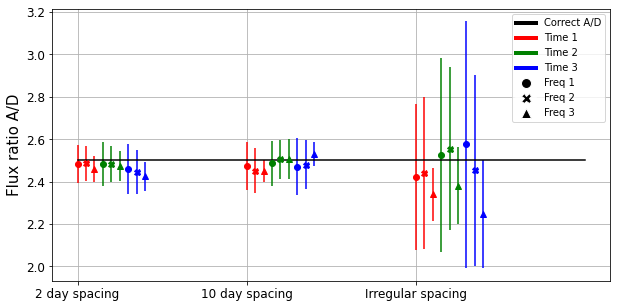

In [190]:
fig = plt.figure(figsize = (10,5))
frame = fig.add_subplot()

frame.plot([1,4], [1/0.4,1/0.4], 'k-')

# [Freq,Meas,Time]
frame.errorbar(x=1.00, y=data_dict["flux_ratio_means"][0][0][0][2], yerr=data_dict["flux_ratio_stds"][0][0][0][2], fmt='ro')
frame.errorbar(x=1.15, y=data_dict["flux_ratio_means"][0][0][1][2], yerr=data_dict["flux_ratio_stds"][0][0][1][2], fmt='go')
frame.errorbar(x=1.30, y=data_dict["flux_ratio_means"][0][0][2][2], yerr=data_dict["flux_ratio_stds"][0][0][2][2], fmt='bo')
frame.errorbar(x=2.00, y=data_dict["flux_ratio_means"][0][1][0][2], yerr=data_dict["flux_ratio_stds"][0][1][0][2], fmt='ro')
frame.errorbar(x=2.15, y=data_dict["flux_ratio_means"][0][1][1][2], yerr=data_dict["flux_ratio_stds"][0][1][1][2], fmt='go')
frame.errorbar(x=2.30, y=data_dict["flux_ratio_means"][0][1][2][2], yerr=data_dict["flux_ratio_stds"][0][1][2][2], fmt='bo')
frame.errorbar(x=3.00, y=data_dict["flux_ratio_means"][0][2][0][2], yerr=data_dict["flux_ratio_stds"][0][2][0][2], fmt='ro')
frame.errorbar(x=3.15, y=data_dict["flux_ratio_means"][0][2][1][2], yerr=data_dict["flux_ratio_stds"][0][2][1][2], fmt='go')
frame.errorbar(x=3.30, y=data_dict["flux_ratio_means"][0][2][2][2], yerr=data_dict["flux_ratio_stds"][0][2][2][2], fmt='bo')

frame.errorbar(x=1.05, y=data_dict["flux_ratio_means"][1][0][0][2], yerr=data_dict["flux_ratio_stds"][1][0][0][2], fmt='rX')
frame.errorbar(x=1.20, y=data_dict["flux_ratio_means"][1][0][1][2], yerr=data_dict["flux_ratio_stds"][1][0][1][2], fmt='gX')
frame.errorbar(x=1.35, y=data_dict["flux_ratio_means"][1][0][2][2], yerr=data_dict["flux_ratio_stds"][1][0][2][2], fmt='bX')
frame.errorbar(x=2.05, y=data_dict["flux_ratio_means"][1][1][0][2], yerr=data_dict["flux_ratio_stds"][1][1][0][2], fmt='rX')
frame.errorbar(x=2.20, y=data_dict["flux_ratio_means"][1][1][1][2], yerr=data_dict["flux_ratio_stds"][1][1][1][2], fmt='gX')
frame.errorbar(x=2.35, y=data_dict["flux_ratio_means"][1][1][2][2], yerr=data_dict["flux_ratio_stds"][1][1][2][2], fmt='bX')
frame.errorbar(x=3.05, y=data_dict["flux_ratio_means"][1][2][0][2], yerr=data_dict["flux_ratio_stds"][1][2][0][2], fmt='rX')
frame.errorbar(x=3.20, y=data_dict["flux_ratio_means"][1][2][1][2], yerr=data_dict["flux_ratio_stds"][1][2][1][2], fmt='gX')
frame.errorbar(x=3.35, y=data_dict["flux_ratio_means"][1][2][2][2], yerr=data_dict["flux_ratio_stds"][1][2][2][2], fmt='bX')

frame.errorbar(x=1.10, y=data_dict["flux_ratio_means"][2][0][0][2], yerr=data_dict["flux_ratio_stds"][2][0][0][2], fmt='r^')
frame.errorbar(x=1.25, y=data_dict["flux_ratio_means"][2][0][1][2], yerr=data_dict["flux_ratio_stds"][2][0][1][2], fmt='g^')
frame.errorbar(x=1.40, y=data_dict["flux_ratio_means"][2][0][2][2], yerr=data_dict["flux_ratio_stds"][2][0][2][2], fmt='b^')
frame.errorbar(x=2.10, y=data_dict["flux_ratio_means"][2][1][0][2], yerr=data_dict["flux_ratio_stds"][2][1][0][2], fmt='r^')
frame.errorbar(x=2.25, y=data_dict["flux_ratio_means"][2][1][1][2], yerr=data_dict["flux_ratio_stds"][2][1][1][2], fmt='g^')
frame.errorbar(x=2.40, y=data_dict["flux_ratio_means"][2][1][2][2], yerr=data_dict["flux_ratio_stds"][2][1][2][2], fmt='b^')
frame.errorbar(x=3.10, y=data_dict["flux_ratio_means"][2][2][0][2], yerr=data_dict["flux_ratio_stds"][2][2][0][2], fmt='r^')
frame.errorbar(x=3.25, y=data_dict["flux_ratio_means"][2][2][1][2], yerr=data_dict["flux_ratio_stds"][2][2][1][2], fmt='g^')
frame.errorbar(x=3.40, y=data_dict["flux_ratio_means"][2][2][2][2], yerr=data_dict["flux_ratio_stds"][2][2][2][2], fmt='b^')

frame.set_ylabel(r'Flux ratio A/D')
frame.set_aspect('auto')
frame.grid()
frame.legend(color_lines, ['Correct A/D', 'Time 1', 'Time 2', 'Time 3', 'Freq 1', 'Freq 2', 'Freq 3'], loc=1)
plt.xticks([1,2,3],['2 day spacing','10 day spacing','Irregular spacing'])

plt.show()

## Recombined data

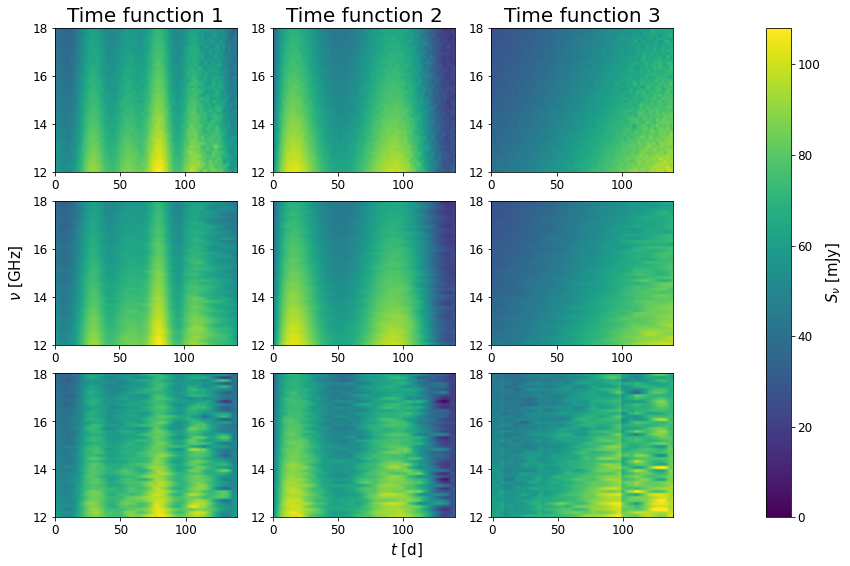

In [210]:
"""Plots of the recombined data. Time functions are shown horizontally, measurement spacing is shown vertically. 
Bandwidth 1."""

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)    # The big subplot
ax11 = fig.add_subplot(3,4,1)
ax12 = fig.add_subplot(3,4,2)
ax13 = fig.add_subplot(3,4,3)
ax21 = fig.add_subplot(3,4,5)
ax22 = fig.add_subplot(3,4,6)
ax23 = fig.add_subplot(3,4,7)
ax31 = fig.add_subplot(3,4,9)
ax32 = fig.add_subplot(3,4,10)
ax33 = fig.add_subplot(3,4,11)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

m = 0

Sv_max = np.max(data_dict["new_dataset"][m][0][0])

image = ax11.imshow(data_dict["new_dataset"][m][0][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][0][0],time_end_meas[m][0][0],bw_low,bw_up1])
ax12.imshow(data_dict["new_dataset"][m][0][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][0][1],time_end_meas[m][0][1],bw_low,bw_up1])
ax13.imshow(data_dict["new_dataset"][m][0][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][0][2],time_end_meas[m][0][2],bw_low,bw_up1])
ax21.imshow(data_dict["new_dataset"][m][1][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][1][0],time_end_meas[m][1][0],bw_low,bw_up1])
ax22.imshow(data_dict["new_dataset"][m][1][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][1][1],time_end_meas[m][1][1],bw_low,bw_up1])
ax23.imshow(data_dict["new_dataset"][m][1][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][1][2],time_end_meas[m][1][2],bw_low,bw_up1])
ax31.imshow(data_dict["new_dataset"][m][2][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][2][0],time_end_meas[m][2][0],bw_low,bw_up1])
ax32.imshow(data_dict["new_dataset"][m][2][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][2][1],time_end_meas[m][2][1],bw_low,bw_up1])
ax33.imshow(data_dict["new_dataset"][m][2][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][2][2],time_end_meas[m][2][2],bw_low,bw_up1])

ax11.set_aspect('auto')
ax12.set_aspect('auto')
ax13.set_aspect('auto')
ax21.set_aspect('auto')
ax22.set_aspect('auto')
ax23.set_aspect('auto')
ax31.set_aspect('auto')
ax32.set_aspect('auto')
ax33.set_aspect('auto')

# Set common labels
ax.set_xlabel(r'$t\ [\mathrm{d}]$')
ax.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')

ax11.set_title('Time function 1')
ax12.set_title('Time function 2')
ax13.set_title('Time function 3')

# fig.colorbar(image, ax=ax)
fig.colorbar(image, ax=ax, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

plt.show()

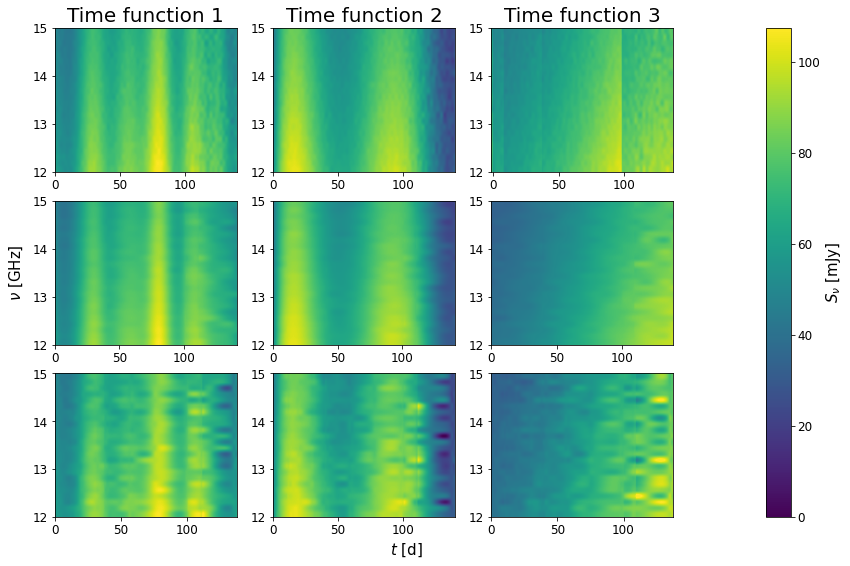

In [211]:
"""Plots of the recombined data. Time functions are shown horizontally, measurement spacing is shown vertically. 
Bandwidth 2."""

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)    # The big subplot
ax11 = fig.add_subplot(3,4,1)
ax12 = fig.add_subplot(3,4,2)
ax13 = fig.add_subplot(3,4,3)
ax21 = fig.add_subplot(3,4,5)
ax22 = fig.add_subplot(3,4,6)
ax23 = fig.add_subplot(3,4,7)
ax31 = fig.add_subplot(3,4,9)
ax32 = fig.add_subplot(3,4,10)
ax33 = fig.add_subplot(3,4,11)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

m = 1

Sv_max = np.max(data_dict["new_dataset"][m][0][0])

image = ax11.imshow(data_dict["new_dataset"][m][0][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][0][0],time_end_meas[m][0][0],bw_low,bw_up2])
ax12.imshow(data_dict["new_dataset"][m][0][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][0][1],time_end_meas[m][0][1],bw_low,bw_up2])
ax13.imshow(data_dict["new_dataset"][m][0][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][0][2],time_end_meas[m][0][2],bw_low,bw_up2])
ax21.imshow(data_dict["new_dataset"][m][1][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][1][0],time_end_meas[m][1][0],bw_low,bw_up2])
ax22.imshow(data_dict["new_dataset"][m][1][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][1][1],time_end_meas[m][1][1],bw_low,bw_up2])
ax23.imshow(data_dict["new_dataset"][m][1][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][1][2],time_end_meas[m][1][2],bw_low,bw_up2])
ax31.imshow(data_dict["new_dataset"][m][2][0], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][2][0],time_end_meas[m][2][0],bw_low,bw_up2])
ax32.imshow(data_dict["new_dataset"][m][2][1], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][2][1],time_end_meas[m][2][1],bw_low,bw_up2])
ax33.imshow(data_dict["new_dataset"][m][2][2], vmin=0, vmax=Sv_max, origin='lower', extent=[time_start_meas[m][2][2],time_end_meas[m][2][2],bw_low,bw_up2])

ax11.set_aspect('auto')
ax12.set_aspect('auto')
ax13.set_aspect('auto')
ax21.set_aspect('auto')
ax22.set_aspect('auto')
ax23.set_aspect('auto')
ax31.set_aspect('auto')
ax32.set_aspect('auto')
ax33.set_aspect('auto')

# Set common labels
ax.set_xlabel(r'$t\ [\mathrm{d}]$')
ax.set_ylabel(r'$\nu\ [\mathrm{GHz}]$')

ax11.set_title('Time function 1')
ax12.set_title('Time function 2')
ax13.set_title('Time function 3')

# fig.colorbar(image, ax=ax)
fig.colorbar(image, ax=ax, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

plt.show()

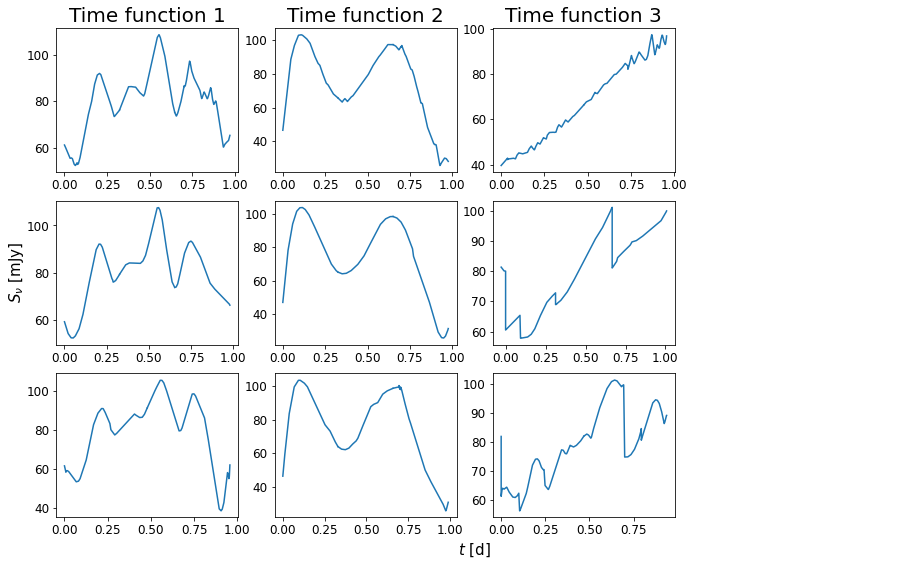

In [212]:
"""Plots of the recombined data. Time functions are shown horizontally, measurement spacing is shown vertically. 
Bandwidth 3."""

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)    # The big subplot
ax11 = fig.add_subplot(3,4,1)
ax12 = fig.add_subplot(3,4,2)
ax13 = fig.add_subplot(3,4,3)
ax21 = fig.add_subplot(3,4,5)
ax22 = fig.add_subplot(3,4,6)
ax23 = fig.add_subplot(3,4,7)
ax31 = fig.add_subplot(3,4,9)
ax32 = fig.add_subplot(3,4,10)
ax33 = fig.add_subplot(3,4,11)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

m = 2

Sv_max = np.max(data_dict["new_dataset"][m][0][0])

image = ax11.plot(times_meas[m][0][0]/step_size, data_dict["new_dataset"][m][0][0][0])
ax12.plot(times_meas[m][0][1]/step_size, data_dict["new_dataset"][m][0][1][0])
ax13.plot(times_meas[m][0][2]/step_size, data_dict["new_dataset"][m][0][2][0])
ax21.plot(times_meas[m][1][0]/step_size, data_dict["new_dataset"][m][1][0][0])
ax22.plot(times_meas[m][1][1]/step_size, data_dict["new_dataset"][m][1][1][0])
ax23.plot(times_meas[m][1][2]/step_size, data_dict["new_dataset"][m][1][2][0])
ax31.plot(times_meas[m][2][0]/step_size, data_dict["new_dataset"][m][2][0][0])
ax32.plot(times_meas[m][2][1]/step_size, data_dict["new_dataset"][m][2][1][0])
ax33.plot(times_meas[m][2][2]/step_size, data_dict["new_dataset"][m][2][2][0])

ax11.set_aspect('auto')
ax12.set_aspect('auto')
ax13.set_aspect('auto')
ax21.set_aspect('auto')
ax22.set_aspect('auto')
ax23.set_aspect('auto')
ax31.set_aspect('auto')
ax32.set_aspect('auto')
ax33.set_aspect('auto')

# Set common labels
ax.set_xlabel(r'$t\ [\mathrm{d}]$')
ax.set_ylabel(r'$S_{\nu}\ [\mathrm{mJy}]$')

ax11.set_title('Time function 1')
ax12.set_title('Time function 2')
ax13.set_title('Time function 3')

# fig.colorbar(image, ax=ax)
# fig.colorbar(image, ax=ax, label=r'$S_{\nu}\ [\mathrm{mJy}]$', pad=0.01)

plt.show()

In [182]:
end_total = time.time()
print(end_total - start_total)

2501.4766359329224
